In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.lines as lines
import seaborn as sns
from scipy import stats as sci_stats
import matplotlib.gridspec as gridspec
colors = sns.color_palette('colorblind')

pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['font.sans-serif'] = 'Noto Sans'

In [10]:
# This dictionary changes the recorded generation numbers to the correct generation numbers
# Since P3 only does 8 gens/day it is very different, the other differences are due to little recording errors
gen_fixer = {70: {'P1': 70, 'P2': 70, 'P3': 56, 'P4': 70},
             550: {'P1': 560, 'P2': 560, 'P3': 448, 'P4': 560},
             1410: {'P1': 1410, 'P2': 1410, 'P3': 1128, 'P4': 1410},
             2640: {'P1': 2640, 'P2': 2640, 'P3': 2104, 'P4': 2640},
             3630: {'P1': 3660, 'P2': 3660, 'P3': 2920, 'P4': 3660},
             5150: {'P1': 5170, 'P2': 5170, 'P3': 4128, 'P4': 5170},
             7530: {'P1': 7550, 'P2': 7560, 'P3': 6040, 'P4': 7560},
             10150: {'P1': 10190, 'P2': 10200, 'P3': 8096, 'P4': 10200}}

In [11]:
vtn_s = pd.read_csv('../../output/VTn_s.csv')
byrm_s = pd.read_csv('../../output/BYxRM_s.csv')
vtn_x = pd.read_csv('../../output/VTn_x.csv')
byrm_x = pd.read_csv('../../output/BYxRM_x.csv')
vtn_s = vtn_s.merge(vtn_x[['Sample', 'Fitness', 'Freq_T0', 's_VLTE', 'Fitness_sub_70']], on='Sample', how='left')
byrm_s = byrm_s.merge(byrm_x, on='Sample', how='left')
conditions = ['P1_YPD_30C', 'P3_SC_37C', 'P1_SC_37C']
vtn_s = vtn_s[vtn_s.Cond.isin(conditions)]
byrm_s = byrm_s[pd.notnull(byrm_s['s'])] # didn't have to do this for vtn_s bc it has no nulls
g70_fits = {i[0]: i[1] for i in np.array(vtn_x[vtn_x.Gen==70][['Cond', 'Fitness']].groupby('Cond').mean().reset_index()[['Cond', 'Fitness']])}

In [12]:
edge_stats = pd.read_csv('data_by_mutation.csv')

In [13]:
# extra data manipulation for DFE stats
edge_avgs = {c: {i[0]:i[1] for i in np.array(vtn_s[vtn_s['Cond']==c][['Edge', 's']].groupby('Edge').mean().reset_index()[['Edge', 's']])} for c in conditions}
# getting a list of mutations that are deleterious on average for each condition:
del_edges = {c: [i for i in edge_avgs[c] if edge_avgs[c][i]<-0.05] for c in edge_avgs}
# getting a list of mutations sorted by how many times they were measured in each condition:
edge_counts = {c: {i[0]:i[1] for i in np.array(vtn_s[vtn_s['Cond']==c][['Edge', 's']].groupby('Edge').count().reset_index()[['Edge', 's']])} for c in conditions}
sorted_edges = {c: sorted(edge_counts[c], key=lambda x: edge_counts[c][x]*-1) for c in edge_counts}
samp_nums = {'P1': 36, 'P3': 33} # numbers of successful assays for each plate (set of clones)
edges_w_full_measurement = {c: [i for i in sorted_edges[c] if edge_counts[c][i]==samp_nums[c[:2]]] for c in sorted_edges}
# Samples must have at least 20 mutations with s measurements in one condition to be included in DFE-level analyses:
svc = {cond: dict(vtn_s[vtn_s.Cond==cond].Sample.value_counts()) for cond in conditions}
vtn_s_for_dfe = vtn_s[vtn_s.apply(lambda r: svc[r['Cond']][r['Sample']]>=20, axis=1)]
byrm_svc = dict(byrm_s.Sample.value_counts())
# cutoff is 50 mutations for by x rm
byrm_s_for_dfe = byrm_s[byrm_s.Sample.apply(lambda s: byrm_svc[s]>=50)]

In [14]:
byrm_dfe = byrm_s_for_dfe[['Sample', 's']].groupby('Sample').mean().reset_index().rename(columns={'s': 'DFE_mean'})
byrm_dfe = byrm_dfe.merge(byrm_s[['Sample', 's']].groupby('Sample').std().reset_index().rename(columns={'s': 'DFE_std'}), on='Sample')
byrm_dfe = byrm_dfe.merge(byrm_s[['Sample', 's']].groupby('Sample').count().reset_index().rename(columns={'s': 's_count'}), on='Sample')
byrm_dfe = byrm_dfe.merge(byrm_x, on='Sample', how='left')
byrm_dfe.head(2)

Sample  DFE_mean   DFE_std  s_count   Fitness
0  LK1-A02 -0.022128  0.024838       72  0.074569
1  LK1-A05 -0.028069  0.033583       72  0.071813

In [15]:
def del_check(row):
    # checks if a mutation is on average deleterious (s <-0.05) in a condition
    return row['Edge'] in del_edges[row['Cond']]

def limited_dfe(row):
    # checks if a mutation is in the top 40 most-measured mutations in a condition
    return row['Edge'] in edges_w_full_measurement[row['Cond']]

vtn_dfe = vtn_s_for_dfe[['Sample', 's']].groupby('Sample').mean().reset_index().rename(columns={'s': 'DFE_mean'})
vtn_dfe = vtn_dfe.merge(vtn_s_for_dfe[['Sample', 's']].groupby('Sample').std().reset_index().rename(columns={'s': 'DFE_std'}), on='Sample')
vtn_dfe = vtn_dfe.merge(vtn_s_for_dfe[['Sample', 's']].groupby('Sample').skew().reset_index().rename(columns={'s': 'DFE_skew'}), on='Sample')
vtn_dfe = vtn_dfe.merge(vtn_s_for_dfe[vtn_s_for_dfe.apply(limited_dfe, axis=1)][['Sample', 's']].groupby('Sample').mean().reset_index().rename(columns={'s': 'DFE_mean_limited'}), on='Sample', how='left')
vtn_dfe = vtn_dfe.merge(vtn_s_for_dfe[vtn_s_for_dfe.apply(limited_dfe, axis=1)][['Sample', 's']].groupby('Sample').count().reset_index().rename(columns={'s': 'limited_count'}), on='Sample', how='left')
vtn_dfe = vtn_dfe.merge(vtn_s_for_dfe[['Sample', 's']].groupby('Sample').count().reset_index().rename(columns={'s': 's_count'}), on='Sample')
vtn_dfe = vtn_dfe.merge(vtn_s_for_dfe[vtn_s_for_dfe.apply(del_check, axis=1)][['Sample', 's']].groupby('Sample').count().reset_index().rename(columns={'s': 'del_s_count'}), on='Sample')
vtn_x['Fitness_std'] = np.std(vtn_x[['Clone_A_s', 'Clone_B_s']], axis=1)
vtn_dfe = vtn_dfe.merge(vtn_x[['Sample', 'Fitness', 'Fitness_std', 'Freq_T0', 's_VLTE']], on='Sample', how='left')

vtn_dfe['Pop'] = vtn_dfe['Sample'].str.split('_').str[1]
vtn_dfe['Env'] = vtn_dfe['Sample'].apply(lambda s: '_'.join(s.split('_')[2:]))
vtn_dfe['Cond'] = vtn_dfe['Pop'].str[:2]+'_'+vtn_dfe['Env']
vtn_dfe['Gen'] = vtn_dfe['Sample'].apply(lambda s: int(s.split('_')[0][1:]))
vtn_dfe['Gen_pop'] = 'G'+vtn_dfe['Gen'].apply(lambda g: str(g))+'_'+vtn_dfe['Pop']

vtn_dfe.head(2)

Sample  DFE_mean   DFE_std  DFE_skew  DFE_mean_limited  \
0   G10150_P1B04_SC_37C -0.071181  0.087681 -1.552533         -0.035623   
1  G10150_P1B04_YPD_30C -0.047015  0.047733 -1.215712         -0.035457   

   limited_count  s_count  del_s_count   Fitness  Fitness_std   Freq_T0  \
0             41       78           20 -0.153673     0.010828  0.201089   
1             68       83           24  0.021696     0.008507  0.311579   

     s_VLTE    Pop      Env        Cond    Gen       Gen_pop  
0       NaN  P1B04   SC_37C   P1_SC_37C  10150  G10150_P1B04  
1  0.026455  P1B04  YPD_30C  P1_YPD_30C  10150  G10150_P1B04

In [16]:
p1_pops = ['P1B04','P1C04','P1C05','P1D03','P1F05','P1G04']
p3_pops = ['P3C03','P3D03','P3F03','P3G02','P3G05','P3G06']
cond_pops = {'P1': p1_pops, 'P3': p3_pops}
color_map = {p1_pops[i]:colors[i] for i in range(len(p1_pops))}
color_map.update({p3_pops[i]:colors[i] for i in range(len(p3_pops))})
cond_to_title = {'P1_YPD_30C': 'YPD 30°C', 'P3_SC_37C': 'SC 37°C', 'P1_SC_37C': 'Evo. YPD 30°C, in SC 37°C',
                 'P3_bad_SC_37C': 'Evo. SC 37°C, in bad media'}

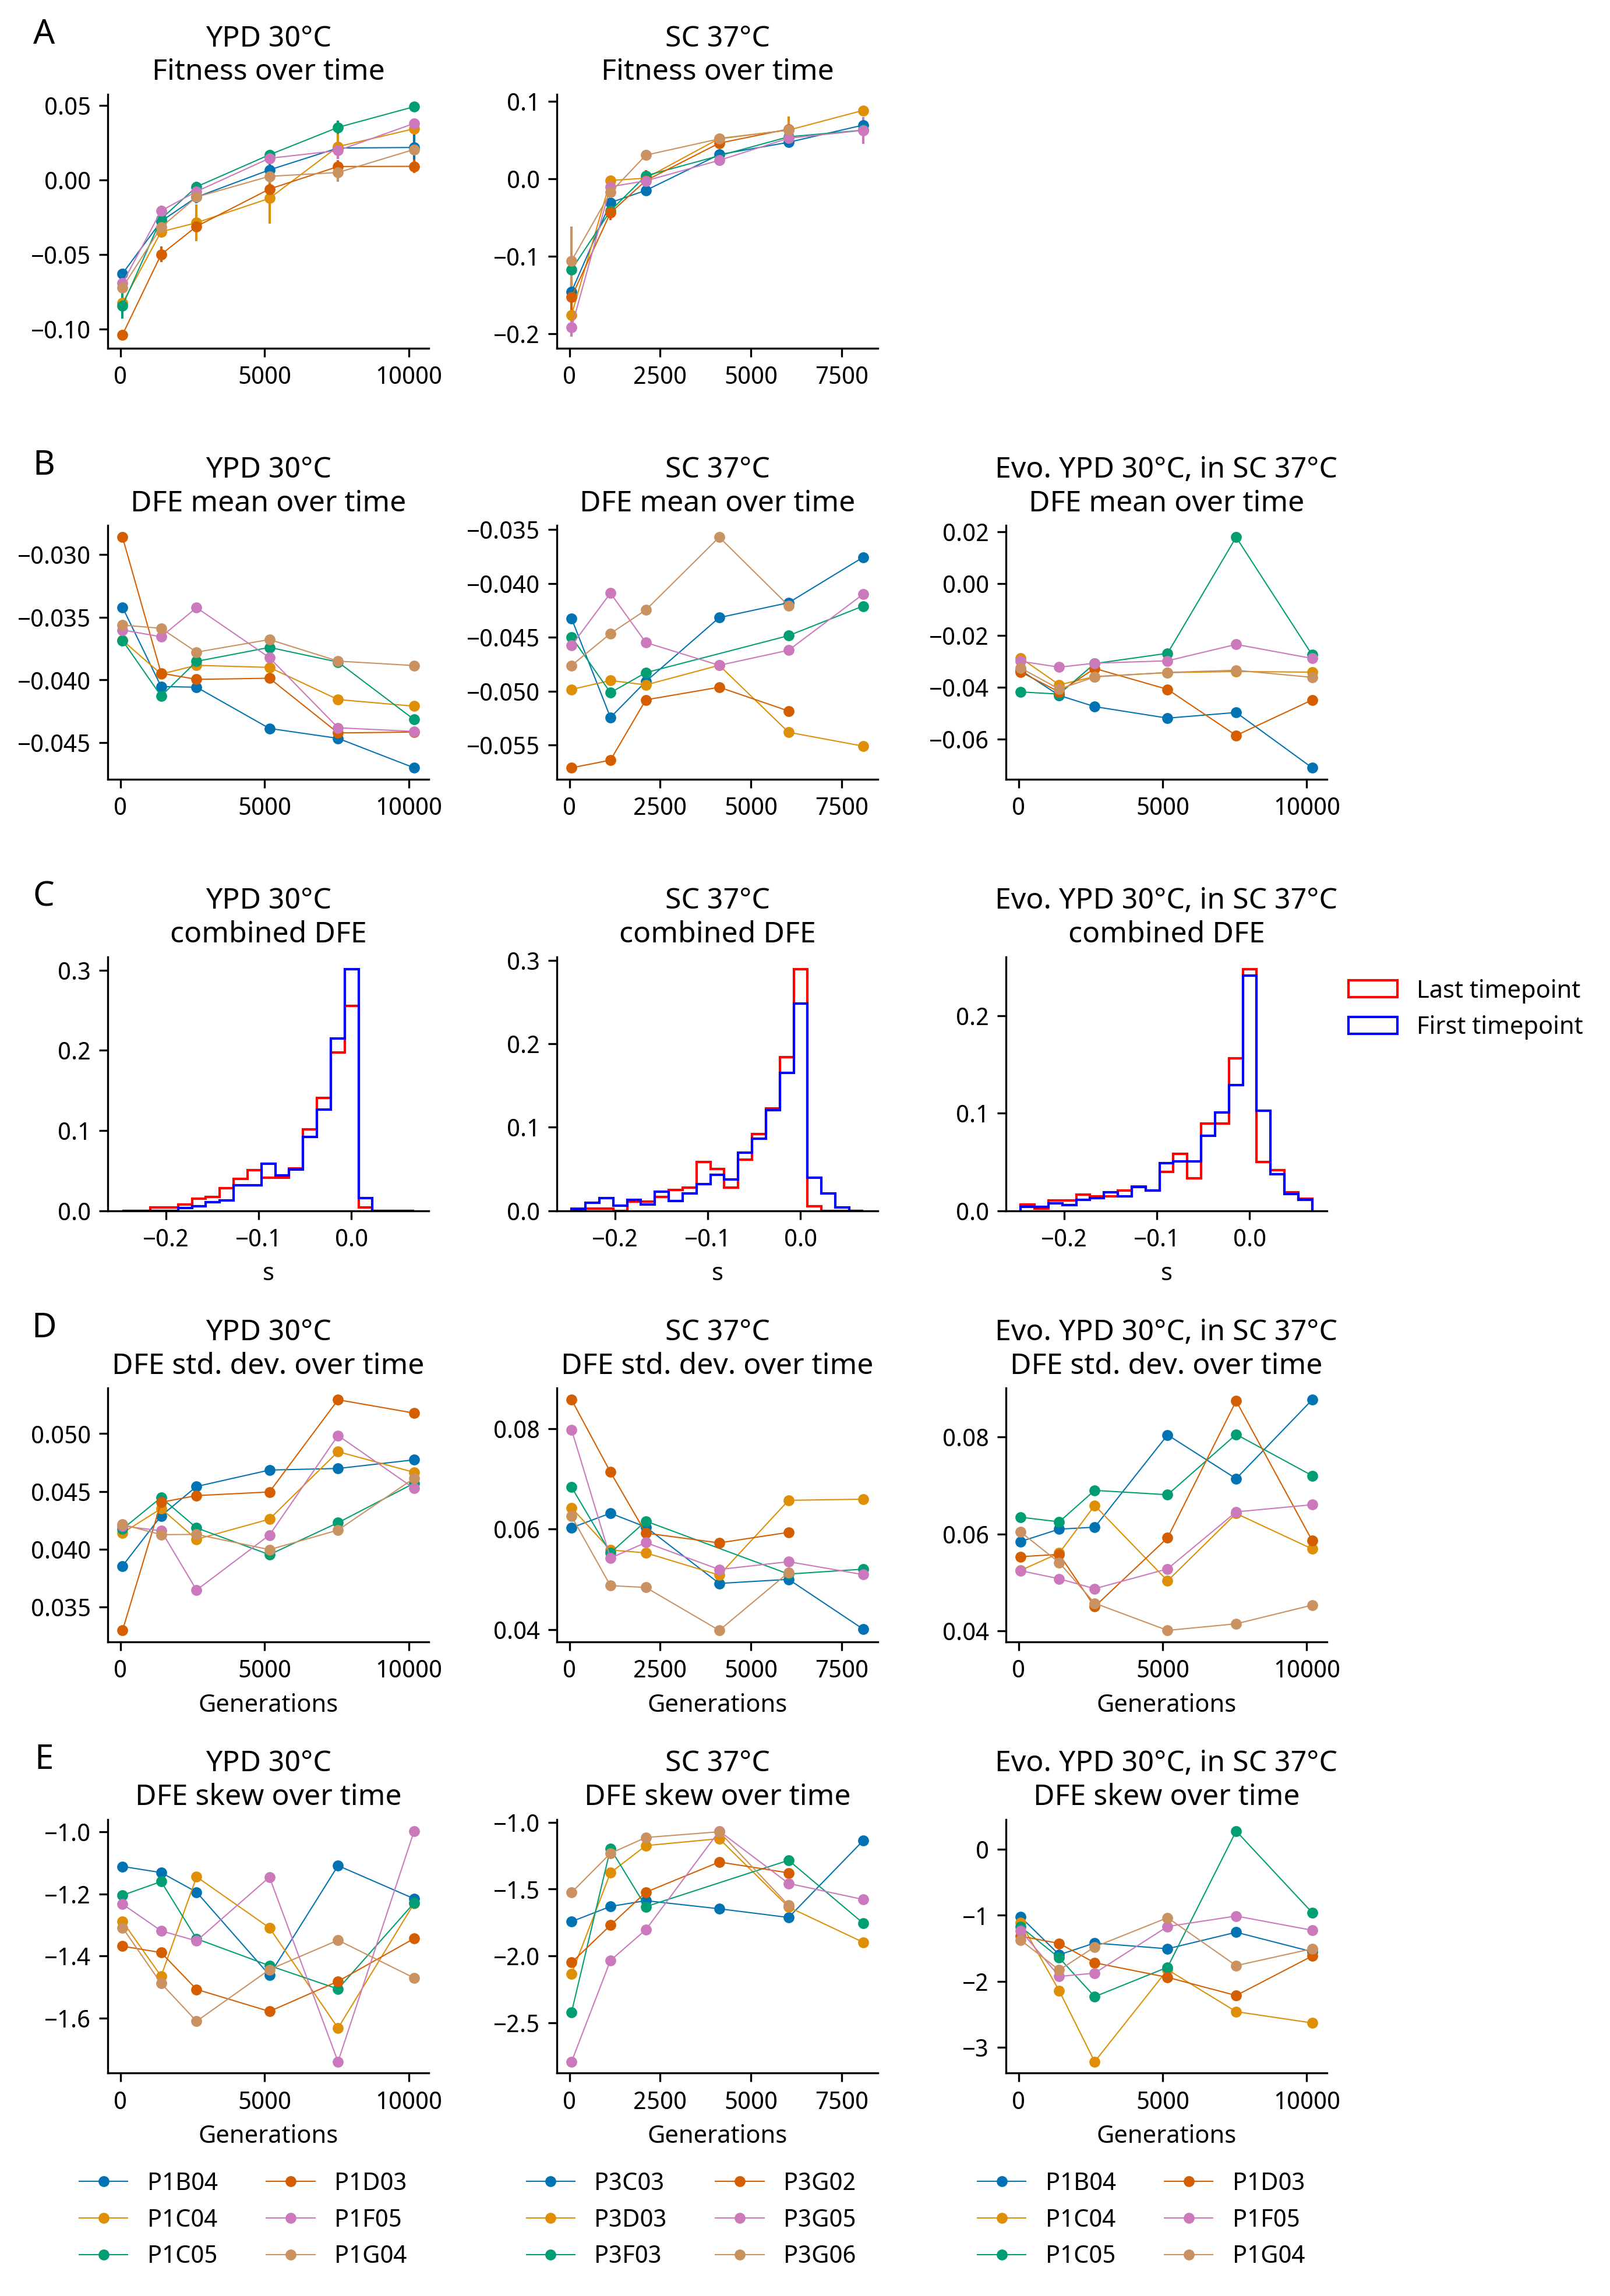

In [17]:
fig, subps = pl.subplots(5, 3, figsize=(9,15), dpi=300)
pl.subplots_adjust(wspace=0.4, hspace=0.7)

fit_spot = 0
mean_spot = 1
dfe_spot = 2
std_spot = 3
skew_spot = 4
for i in range(3):
    cond = conditions[i]
    td = vtn_dfe[vtn_dfe.Cond==cond]
    for pop in cond_pops[cond.split('_')[0]]:
        ttd = td[td.Pop==pop].sort_values('Gen')
        gen_rec = [gen_fixer[g][cond.split('_')[0]] for g in ttd['Gen']]
        if sci_stats.linregress(gen_rec, ttd['DFE_std'])[3]<0.05:
            lab = pop+'*'
        else:
            lab = pop
        if cond != 'P1_SC_37C':
            subps[fit_spot][i].errorbar(x=gen_rec, y=ttd['Fitness'], yerr=ttd['Fitness_std'], linestyle='-', marker='.', markersize=7, elinewidth=1, linewidth=0.5, color=color_map[pop], label=pop)
        else:
            subps[fit_spot][i].set_visible(False)
        subps[mean_spot][i].plot(gen_rec, ttd['DFE_mean'], linestyle='-', marker='.', markersize=7, linewidth=0.5, color=color_map[pop], label=lab)
        
        subps[std_spot][i].plot(gen_rec, ttd['DFE_std'], linestyle='-', marker='.', markersize=7, linewidth=0.5, color=color_map[pop], label=lab)
        subps[skew_spot][i].plot(gen_rec, ttd['DFE_skew'], linestyle='-', marker='.', markersize=7, linewidth=0.5, color=color_map[pop], label=pop)
        #print(cond, pop, sci_stats.linregress(ttd['Gen'], ttd['DFE_std'])[3])
    #print(cond, 'ALL', sci_stats.linregress(td['Gen'], td['DFE_std'])[3])
    subps[fit_spot][i].set_title(cond_to_title[cond]+'\nFitness over time')
    subps[mean_spot][i].set_title(cond_to_title[cond]+'\nDFE mean over time')
    subps[std_spot][i].set_title(cond_to_title[cond]+'\nDFE std. dev. over time')
    subps[skew_spot][i].set_title(cond_to_title[cond]+'\nDFE skew over time')
    subps[std_spot][i].set_xlabel('Generations')
    subps[skew_spot][i].set_xlabel('Generations')
    subps[skew_spot][i].legend(frameon=False, bbox_to_anchor=(1, -0.3), ncol=2)
    td = vtn_s[vtn_s.Cond==cond]
    bottom_dfe = td[td['Gen']==70]['s']
    top_dfe = td[td['Gen']==10150]['s']
    bin_lefts = [(-16.15+i)*0.015-0.005 for i in range(22)]
    subps[dfe_spot][i].hist(top_dfe, bins=bin_lefts, label='Last timepoint', histtype="step", color="r", weights=np.ones_like(top_dfe)/float(len(top_dfe)))
    subps[dfe_spot][i].hist(bottom_dfe, bins=bin_lefts, label='First timepoint', histtype="step", color="b", weights=np.ones_like(bottom_dfe)/float(len(bottom_dfe)))
    subps[dfe_spot][i].set_title(cond_to_title[cond]+ '\ncombined DFE')
    subps[dfe_spot][i].set_xlabel('s')
subps[dfe_spot][2].legend(frameon=False, bbox_to_anchor=(1,1))

#subps[0][0].set_ylabel('Fitness')
#subps[1][0].set_ylabel('DFE mean')
subps[0][0].annotate('A', fontsize=14, xy=(-0.2, 1.2), xycoords="axes fraction", horizontalalignment="center")
subps[1][0].annotate('B', fontsize=14, xy=(-0.2, 1.2), xycoords="axes fraction", horizontalalignment="center")
subps[2][0].annotate('C', fontsize=14, xy=(-0.2, 1.2), xycoords="axes fraction", horizontalalignment="center")
subps[3][0].annotate('D', fontsize=14, xy=(-0.2, 1.2), xycoords="axes fraction", horizontalalignment="center")
subps[4][0].annotate('E', fontsize=14, xy=(-0.2, 1.2), xycoords="axes fraction", horizontalalignment="center")

sns.despine()
fig.savefig('../../Figures/supp_figs/DFE_additional_stats.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

P1_YPD_30C P1B04 0.0009857473592677663
P1_YPD_30C P1C04 0.001958893006707298
P1_YPD_30C P1C05 0.32048010385445674
P1_YPD_30C P1D03 0.0036067061409577696
P1_YPD_30C P1F05 0.11078547272554116
P1_YPD_30C P1G04 0.031575250585547374
P1_YPD_30C ALL 3.642288224746397e-06
P3_SC_37C P3C03 0.46261190448732514
P3_SC_37C P3D03 0.4226440322716699
P3_SC_37C P3F03 0.5408102201731082
P3_SC_37C P3G02 0.07257646869402623
P3_SC_37C P3G05 0.7029867226237592
P3_SC_37C P3G06 0.11029960476589715
P3_SC_37C ALL 0.18427843948075132
P1_SC_37C P1B04 0.5894258916649695
P1_SC_37C P1C04 0.03212435016135687
P1_SC_37C P1C05 0.007394226699226962
P1_SC_37C P1D03 0.44415708299394224
P1_SC_37C P1F05 nan
P1_SC_37C P1G04 0.39567408432839996
P1_SC_37C ALL nan


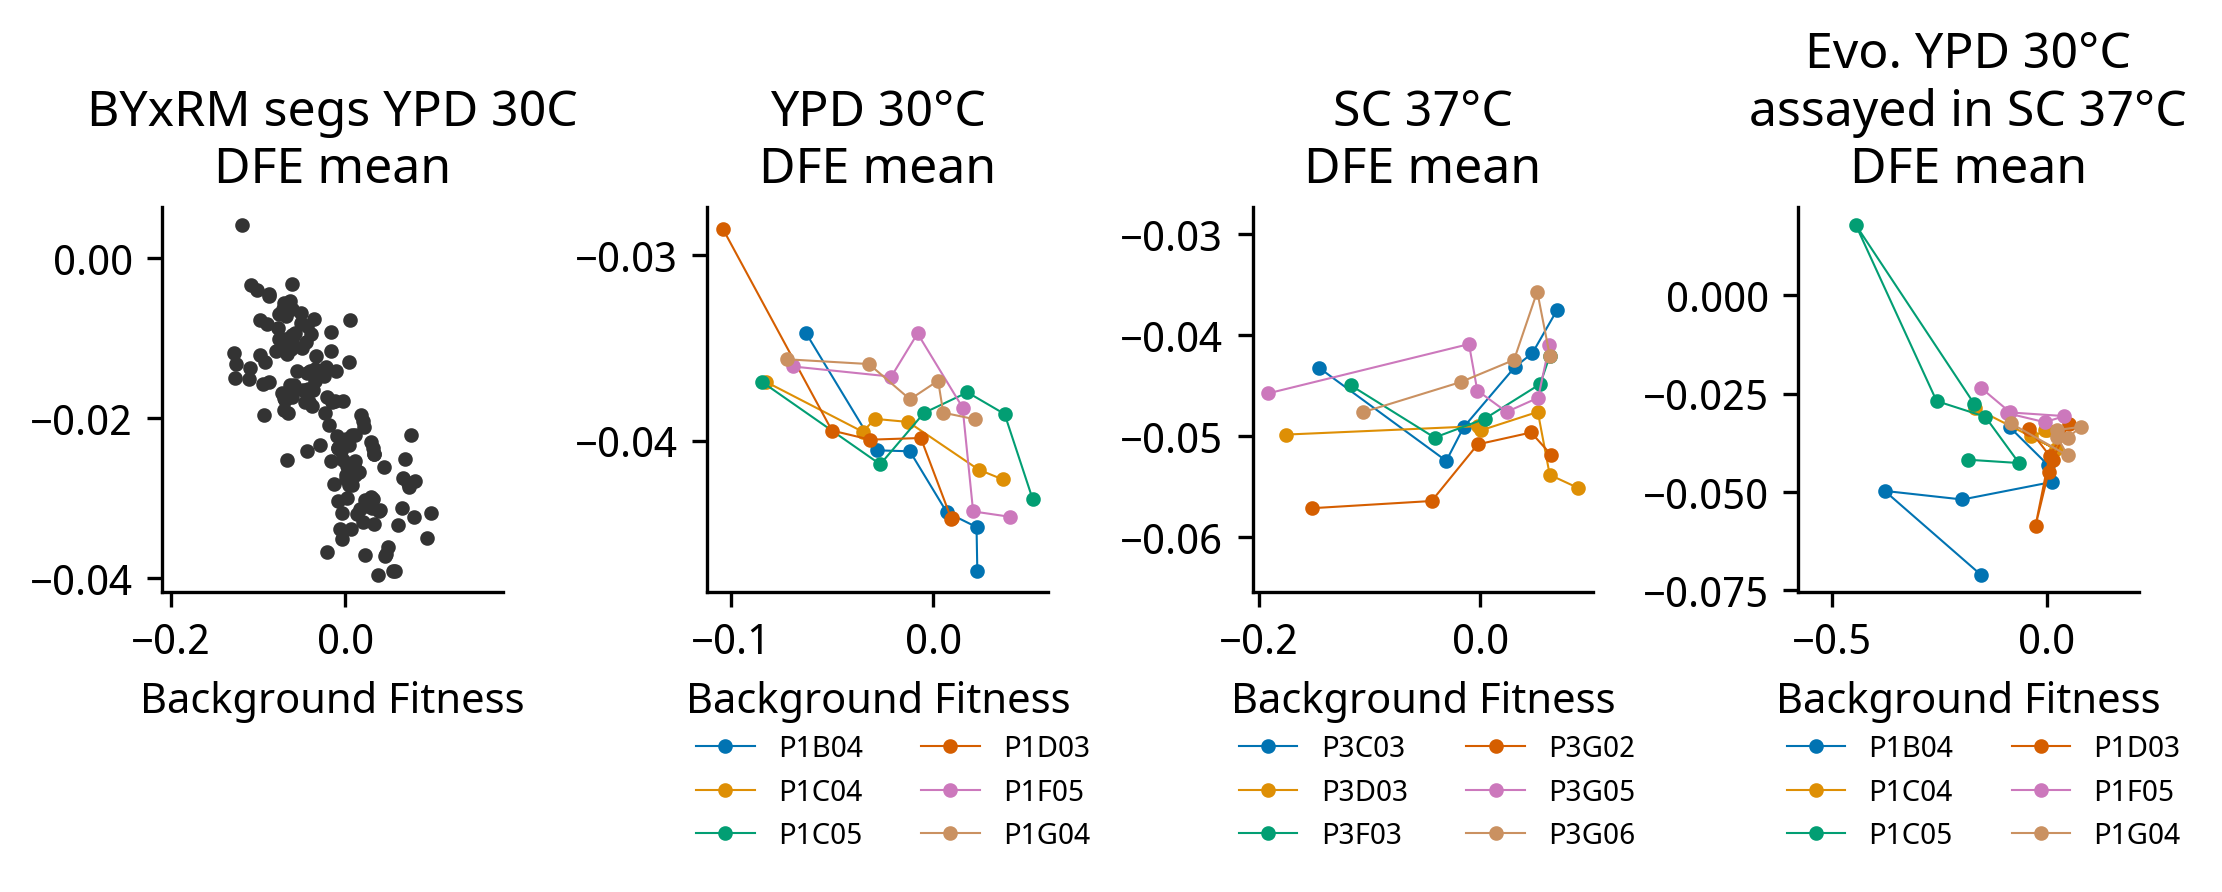

In [18]:
def standardize_aspect(subs):
    aspects = []
    for sub in subs:
        xlim = sub.get_xlim()
        ylim = sub.get_ylim()
        xr = xlim[1]-xlim[0]
        yr = ylim[1]-ylim[0]
        aspects.append(xr/yr)
    #print(aspects)
    ave_aspect = np.mean(aspects)
    for sub in subs:
        xlim = sub.get_xlim()
        ylim = sub.get_ylim()
        xr = xlim[1]-xlim[0]
        yr = ylim[1]-ylim[0]
        a = xr/yr
        if a > ave_aspect:
            new_yr = xr/ave_aspect
            ymid = (ylim[1]+ylim[0])/2
            sub.set_ylim([ymid-new_yr/2, ymid+new_yr/2])
        else:
            new_xr = yr*ave_aspect
            xmid = (xlim[1]+xlim[0])/2
            sub.set_xlim([xmid-new_xr/2, xmid+new_xr/2])
        xlim = sub.get_xlim()
        ylim = sub.get_ylim()
        xr = xlim[1]-xlim[0]
        yr = ylim[1]-ylim[0]
        #print('standard:', xr/yr)

fig, subs = pl.subplots(1, 4, figsize=(8.5,1.7), dpi=300)
pl.subplots_adjust(wspace=0.6)
x_width = 0.55

subs[0].plot(byrm_dfe['Fitness'], byrm_dfe['DFE_mean'], linestyle='', marker='.', markersize=5, linewidth=1, color="#333333")
subs[0].set_title('BYxRM segs YPD 30C\nDFE mean')
#mid = (np.min(byrm_dfe['Fitness']) + np.max(byrm_dfe['Fitness']))/2
#subs[0].set_xlim([mid-x_width/2, mid+x_width/2])
for i in range(1, 4):
    td = vtn_dfe[vtn_dfe.Cond==conditions[i-1]]
    all_x = []
    for pop in cond_pops[conditions[i-1].split('_')[0]]:
        ttd = td[td.Pop==pop].sort_values('Gen')
        all_x += [i for i in ttd['Fitness'] if not pd.isnull(i)]
        subs[i].plot(ttd['Fitness'], ttd['DFE_mean'], linestyle='-', marker='.', markersize=5, linewidth=0.5, color=color_map[pop], label=pop)
        print(conditions[i-1], pop, sci_stats.linregress(ttd['Fitness'], ttd['DFE_mean'])[3])
    print(conditions[i-1], 'ALL', sci_stats.linregress(td['Fitness'], td['DFE_mean'])[3])
    #mid = (np.min(all_x) + np.max(all_x))/2
    #subs[i].set_xlim([mid-x_width/2, mid+x_width/2])
    subs[i].set_title(cond_to_title[conditions[i-1]].replace(', ', '\nassayed ')+'\nDFE mean')
    subs[i].legend(frameon=False, bbox_to_anchor=(1.2, -0.3), ncol=2, fontsize=7)
sns.despine()
standardize_aspect(subs)
for i in range(4):
    subs[i].set_xlabel('Background Fitness')
fig.savefig('../../Figures/supp_figs/DFE_Fitness_S2.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

## Finally, let's make a fake dataset where missing measurements are filled in with their average fitness effect

In [20]:
mat = []
for samp in set(vtn_s_for_dfe.Sample):
    for edge in set(vtn_s_for_dfe.Edge):
        td = vtn_s_for_dfe[(vtn_s_for_dfe.Sample==samp) & (vtn_s_for_dfe.Edge==edge)]
        if len(td) == 1:
            mat.append([samp, edge, td.iloc[0]['s']])
        else:
            s = samp.split('_')
            cond = '_'.join([s[1][:2]]+s[-2:])
            mat.append([samp, edge, edge_avgs[cond][edge]])
vtn_s_filled = pd.DataFrame(mat, columns=['Sample', 'Edge', 's'])

In [21]:
vtn_dfe_filled = vtn_s_filled[['Sample', 's']].groupby('Sample').mean().reset_index().rename(columns={'s': 'DFE_mean'})
vtn_dfe_filled = vtn_dfe_filled.merge(vtn_x[['Sample', 'Fitness', 'Freq_T0', 's_VLTE']], on='Sample', how='left')
vtn_dfe_filled['Pop'] = vtn_dfe_filled['Sample'].str.split('_').str[1]
vtn_dfe_filled['Env'] = vtn_dfe_filled['Sample'].apply(lambda s: '_'.join(s.split('_')[2:]))
vtn_dfe_filled['Cond'] = vtn_dfe_filled['Pop'].str[:2]+'_'+vtn_dfe_filled['Env']
vtn_dfe_filled['Gen'] = vtn_dfe_filled['Sample'].apply(lambda s: int(s.split('_')[0][1:]))
vtn_dfe_filled.head(2)

Sample  DFE_mean   Fitness   Freq_T0    s_VLTE    Pop  \
0   G10150_P1B04_SC_37C -0.071022 -0.153673  0.201089       NaN  P1B04   
1  G10150_P1B04_YPD_30C -0.050368  0.021696  0.311579  0.026455  P1B04   

       Env        Cond    Gen  
0   SC_37C   P1_SC_37C  10150  
1  YPD_30C  P1_YPD_30C  10150

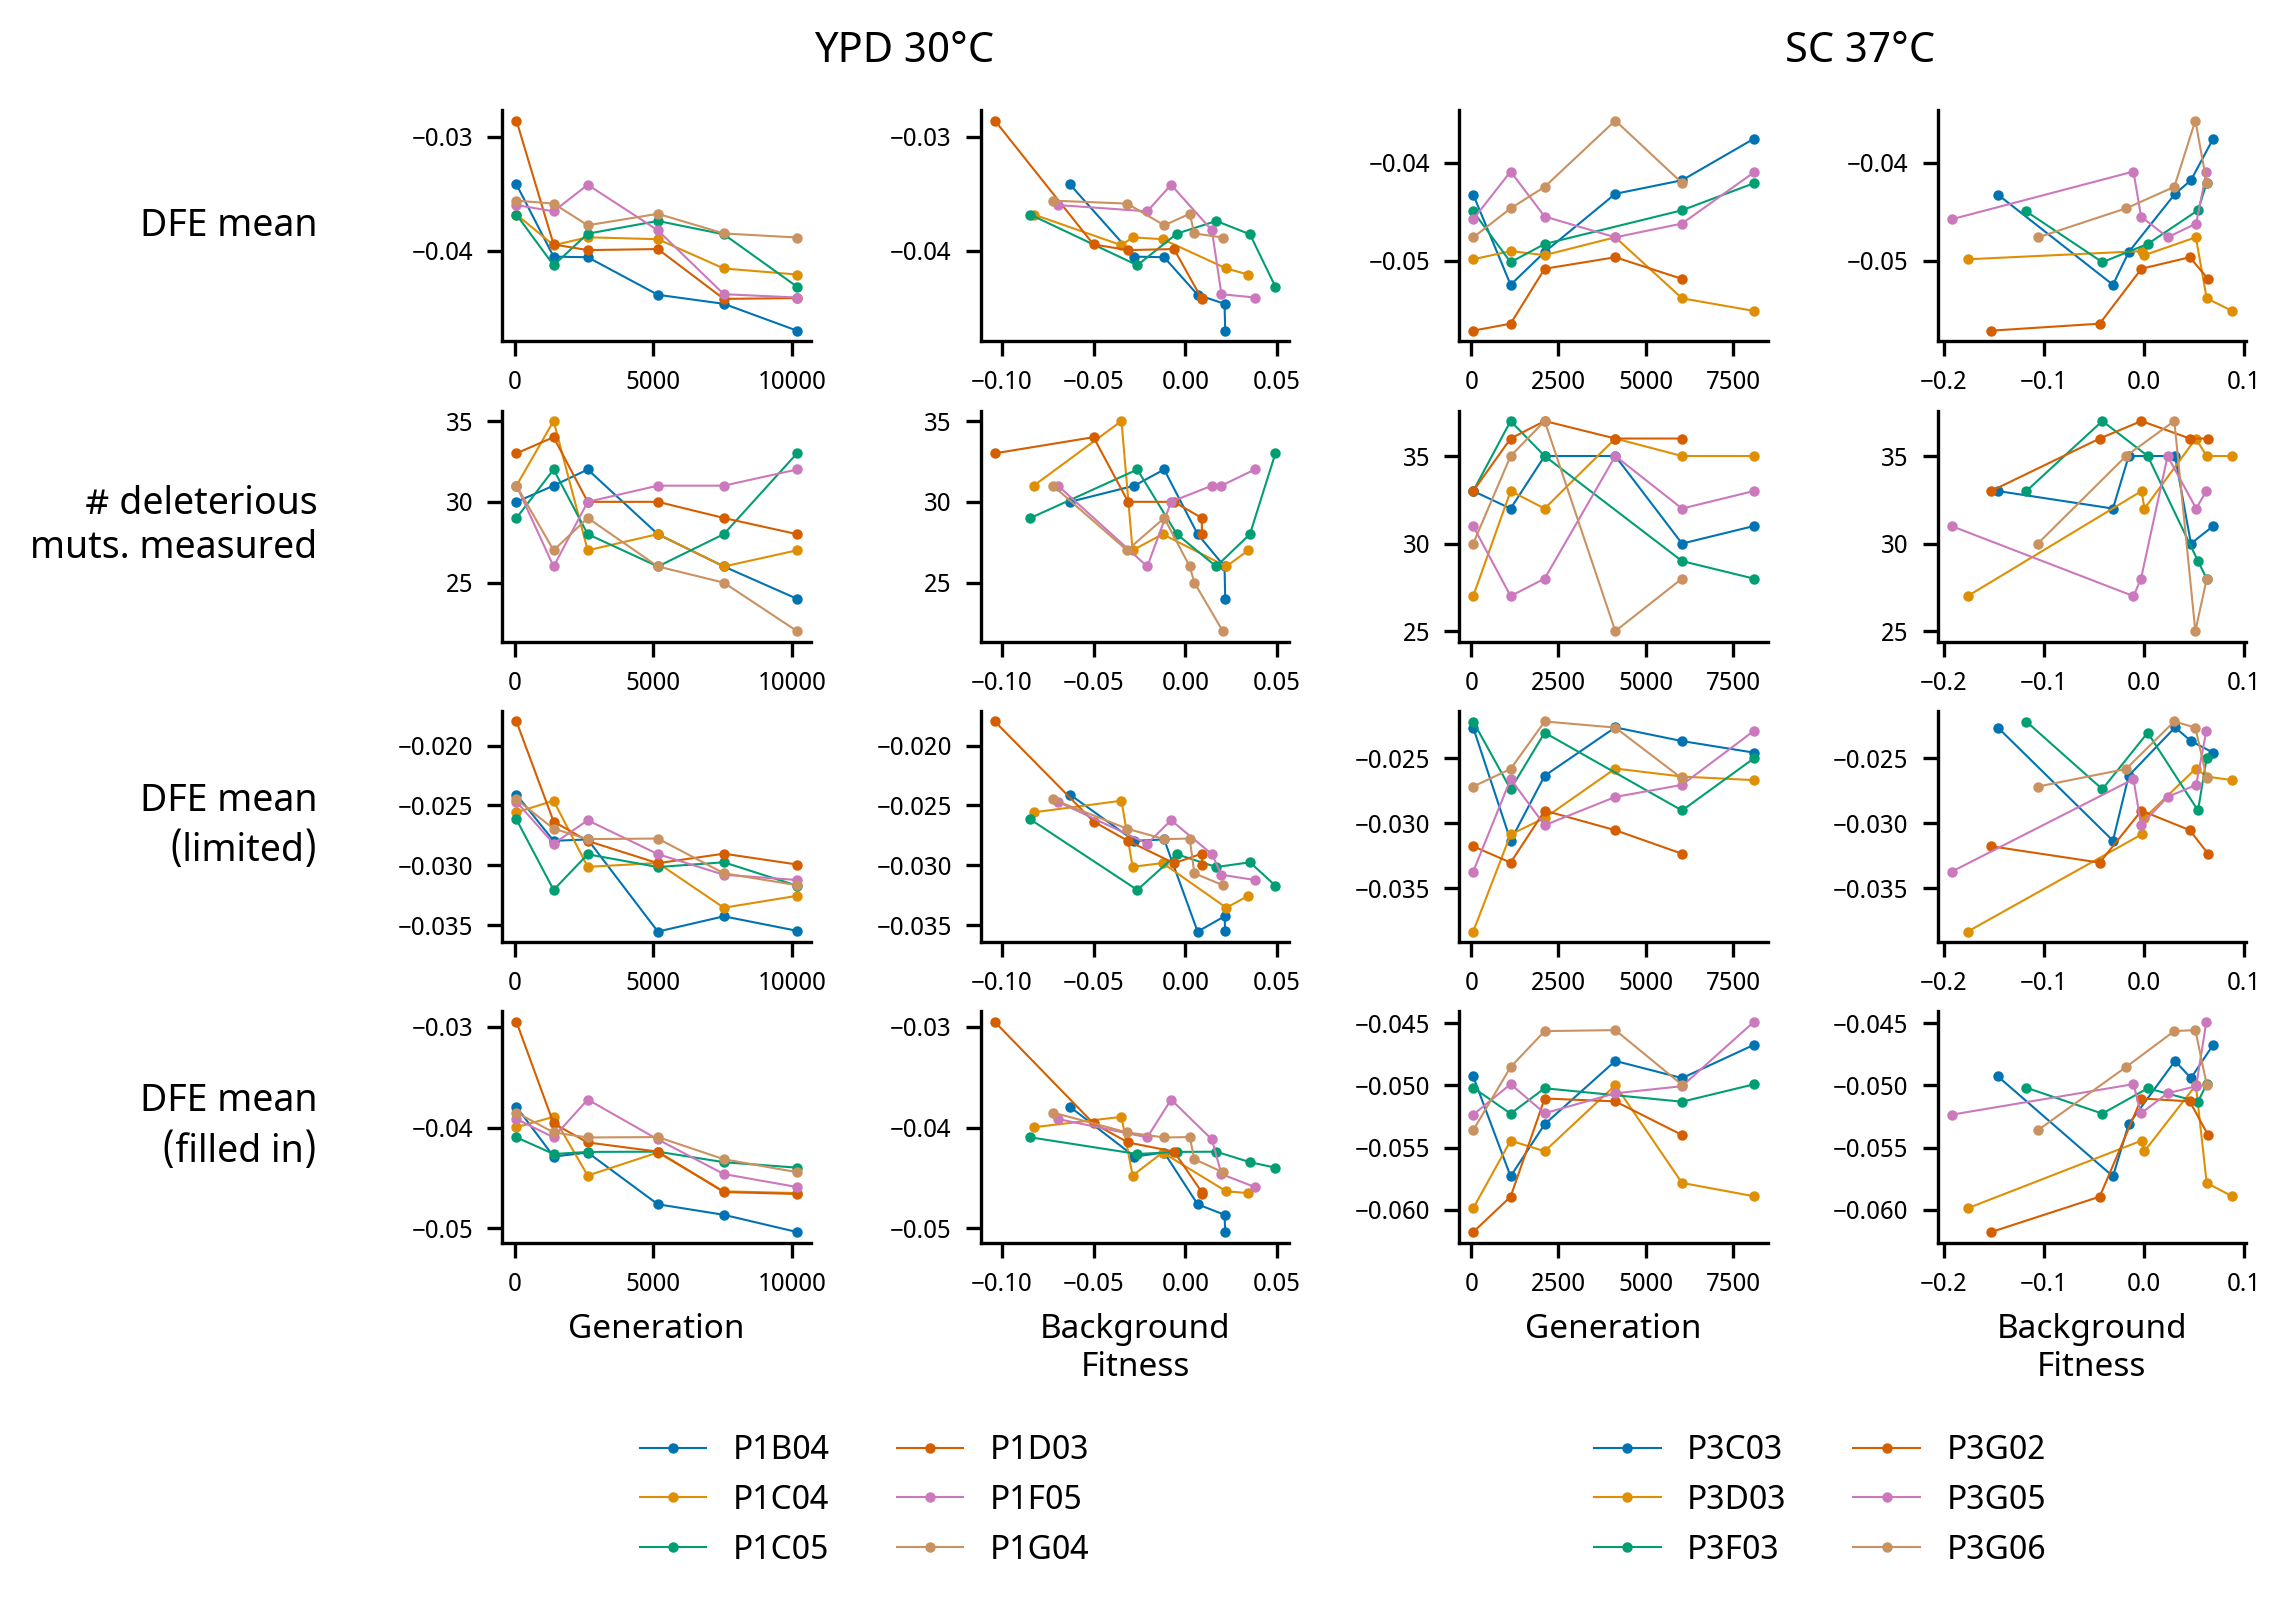

In [22]:
fig, subs = pl.subplots(4, 4, figsize=(7.5, 5), dpi=300)
pl.subplots_adjust(wspace=0.55, hspace=0.3)
ms = 3 
for i in range(2):
    cond = conditions[i]
    tdf = vtn_dfe_filled[vtn_dfe_filled.Cond==conditions[i]]
    td = vtn_dfe[vtn_dfe.Cond==conditions[i]]
    for pop in cond_pops[conditions[i].split('_')[0]]:
        ttdf = tdf[tdf.Pop==pop].sort_values('Gen')
        ttd = td[td.Pop==pop].sort_values('Gen')
        gen_rec = [gen_fixer[g][cond.split('_')[0]] for g in ttd['Gen']]
        subs[0][i*2].plot(gen_rec, ttd['DFE_mean'], linestyle='-', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
        subs[0][i*2+1].plot(ttd['Fitness'], ttd['DFE_mean'], linestyle='-', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
        subs[1][i*2].plot(gen_rec, ttd['del_s_count'], linestyle='-', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
        subs[1][i*2+1].plot(ttd['Fitness'], ttd['del_s_count'], linestyle='-', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
        subs[2][i*2].plot(gen_rec, ttd['DFE_mean_limited'], linestyle='-', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
        subs[2][i*2+1].plot(ttd['Fitness'], ttd['DFE_mean_limited'], linestyle='-', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
        subs[3][i*2].plot(gen_rec, ttdf['DFE_mean'], linestyle='-', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
        subs[3][i*2+1].plot(ttdf['Fitness'], ttdf['DFE_mean'], linestyle='-', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
    for j in range(4):
        subs[j][i*2].tick_params(labelsize=6)
        subs[j][i*2+1].tick_params(labelsize=6)
    subs[3][i*2].legend(frameon=False, bbox_to_anchor=(2, -0.7), ncol=2, fontsize=8)
    subs[0][i*2].set_title(cond_to_title[conditions[i]], x=1.3, fontsize=10, y=1.1)
    subs[3][i*2].set_xlabel('Generation', fontsize=8)
    subs[3][i*2+1].set_xlabel('Background\nFitness', fontsize=8)
    
subs[0][0].annotate('DFE mean', xy=(-0.6, 0.5), xycoords="axes fraction", ha='right', va='center', fontsize=9)
subs[1][0].annotate('# deleterious\nmuts. measured', xy=(-0.6, 0.5), xycoords="axes fraction", ha='right', va='center', fontsize=9)
subs[2][0].annotate('DFE mean\n(limited)', xy=(-0.6, 0.5), xycoords="axes fraction", ha='right', va='center', fontsize=9)
subs[3][0].annotate('DFE mean\n(filled in)', xy=(-0.6, 0.5), xycoords="axes fraction", ha='right', va='center', fontsize=9)
sns.despine()
fig.savefig('../../Figures/supp_figs/DFE_missing_data_all.png', background='transparent', bbox_inches='tight', pad_inches=0.1)


In [30]:
def plot_one(sub, cond, edge, axis_color, xvar='Fitness', lw=0.5):
    td = vtn_s[(vtn_s['Edge']==edge) & (vtn_s['Cond']==cond) & (vtn_s['num_cbcs']>=5)]
    sub.axhline(0, linestyle='dashed', color='k', linewidth=lw/2, alpha=0.6)
    for pop in cond_pops[cond.split('_')[0]]:
        ttd = td[td.Pop==pop].sort_values('Gen')
        ls = ''
        if xvar == 'Gen': ls = '-'
        sub.errorbar(x=ttd[xvar], y=ttd['s'], yerr=ttd['stderr'], linestyle=ls, marker='.', markersize=2, linewidth=lw, color=color_map[pop], label=pop)
    #sub.set_ylim([-0.15, 0.1])
    sub.tick_params(which='both', labelsize=6, colors=axis_color)
    sub.spines['bottom'].set_color(axis_color)
    sub.spines['left'].set_color(axis_color)
    
    
def plot_one_byrm(sub, edge, axis_color):
    ttd = byrm_s[(byrm_s['Edge']==edge) & (byrm_s['num_cbcs']>=5)]
    sub.axhline(0, linestyle='dashed', color='k', linewidth=0.25, alpha=0.6)
    sub.errorbar(x=ttd['Fitness'], y=ttd['s'], yerr=ttd['stderr'], linestyle='', marker='.', markersize=1, linewidth=0.5, color='k')
    #sub.set_ylim([-0.15, 0.1])
    sub.tick_params(which='both', labelsize=6, colors=axis_color)
    sub.spines['bottom'].set_color(axis_color)
    sub.spines['left'].set_color(axis_color)
    
def tiny_plot(sub, yvals, axis_color, xlab='Fitness'):
    sub.plot([0,1], yvals, c=axis_color)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_ylim([-2,2])
    sub.set_ylabel('s', color=axis_color, rotation='horizontal', fontsize=10, verticalalignment='center', y=0.49, labelpad=6)
    sub.set_xlabel(xlab, color=axis_color, rotation='horizontal', fontsize=8)
    sub.spines['bottom'].set_color(axis_color)
    sub.spines['left'].set_color(axis_color)
    sns.despine(ax=sub)

In [31]:
def cross_plot(c1, c2, color1, color2, n1, n2, examples, outname, xvar='Fitness', mod=''):
    calls = ['-', 'NS', '+']
    fig = pl.figure(figsize=(7.5, 6), dpi=300)
    gs0 = gridspec.GridSpec(11, 22)
    for i in range(3):
        for j in range(3):
            tmp_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[i*4:i*4+2,j*8:j*8+6])
            subs = [pl.Subplot(fig, tmp_gs[0])]
            subs.append(pl.Subplot(fig, tmp_gs[1], sharey=subs[0]))
            jnk = [fig.add_subplot(s) for s in subs] 
            pl.subplots_adjust(wspace=0.2)
            call1 = calls[i]
            call2 = calls[j]
            td = edge_stats[(edge_stats.Type=='Experiment') & (edge_stats[c1+mod+'_call']==call1) & (edge_stats[c2+mod+'_call']==call2)]
            if len(td) > 0:
                print(call1, call2, list(td['Gene_Use']))
                plot_one(subs[0], c1, examples[call1+'_'+call2], color1, xvar=xvar)
                if c2 == 'BYxRM':
                    plot_one_byrm(subs[1], examples[call1+'_'+call2], color2)
                else:
                    plot_one(subs[1], c2, examples[call1+'_'+call2], color2, xvar=xvar)
                print(len(td[td['Edge']==examples[call1+'_'+call2]]))
                if len(td[td['Edge']==examples[call1+'_'+call2]]) > 0:
                    subs[0].annotate(td[td['Edge']==examples[call1+'_'+call2]]['Gene_Use'].iloc[0], xy=(1.1,1.1), xycoords='axes fraction', fontfamily='Noto serif', fontsize=12, horizontalalignment='center')
                sns.despine(ax=subs[0])
                sns.despine(ax=subs[1])
                subs[0].annotate('('+str(len(td)) + ' total examples)', xy=(1.1,-0.5), xycoords='axes fraction', fontfamily='Noto serif', fontsize=9, horizontalalignment='center')
            else:
                subs[0].set_xticks([])
                subs[0].set_yticks([])
                sns.despine(ax=subs[0], left=True, bottom=True)
                subs[1].remove()
                subs[0].annotate('('+str(len(td)) + ' total examples)', xy=(1.1,0.5), xycoords='axes fraction', fontfamily='Noto serif', fontsize=9, horizontalalignment='center')

            #subs[1].set_yticks([])
            if i == 0:
                #subs[0].annotate(calls[j], xy=(1.1,2.2), xycoords='axes fraction', fontsize=25, horizontalalignment='center', color=color2)
                ax = fig.add_axes([0.2+j*0.28, 0.98, 0.065, 0.065])
                tiny_plot(ax, [0,j-1], color2, xlab=xvar)
                if j == 0:
                    subs[0].annotate(n1.replace(' ', '\n'), xy=(-1.11,2.2), xycoords='axes fraction', fontsize=25, horizontalalignment='center', verticalalignment='center', color=color1)
                if j == 1:
                    subs[0].annotate(n2, xy=(1.1,2.7), xycoords='axes fraction', fontsize=25, horizontalalignment='center', color=color2)
            if j == 0:
                #subs[0].annotate(calls[i], xy=(-1.1,0.6), xycoords='axes fraction', fontsize=25, horizontalalignment='center', verticalalignment='center', color=color1)
                ax = fig.add_axes([-0.02, 0.24+(2-i)*0.27, 0.065, 0.065])
                tiny_plot(ax, [0,i-1], color1)
            pl.setp(subs[1].get_yticklabels(), visible=False)

    shift = -0.05
    fig.add_artist(lines.Line2D([0.09, 0.91], [0.43+shift, 0.43+shift], c='k', linewidth=0.25))
    fig.add_artist(lines.Line2D([0.09, 0.91], [0.71+shift, 0.71+shift], c='k', linewidth=0.25))
    fig.add_artist(lines.Line2D([0.35, 0.35], [0.17+shift, 0.98+shift], c='k', linewidth=0.25))
    fig.add_artist(lines.Line2D([0.635, 0.635], [0.17+shift, 0.98+shift], c='k', linewidth=0.25))
    fig.add_artist(lines.Line2D([0.4, 0.62], [1.08, 1.08], c=color2, linewidth=1))
    fig.add_artist(lines.Line2D([-0.04, 0.09], [0.97, 0.97], c=color1, linewidth=1))
    fig.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)

- - ['nearby OST4', 'in NOP16', 'in LAT1', 'in RPL16A', 'in SPT8', 'in PIH1', 'in FUN30', 'in OCA1', 'in FLC2', 'in PHO4', 'in MPC2', 'in GPP1', 'in HOS4', 'in RPL31B', 'nearby NCP1', 'in SCJ1', 'in STE24', 'in SLX5', 'nearby YLR264C-A', 'nearby CCW12', 'in RPL2A', 'in RPL35B', 'in UBP3', 'in PDE2', 'nearby KRE6', 'in RSC30', 'in RPL31B', 'in SPT8']
1
- NS ['nearby MET4', 'in MAC1', 'in UME6']
1
NS - ['nearby RPL16A', 'in CPR6', 'in RPL26B', 'in FUN30', 'in SLX8', 'nearby SFP1', 'nearby NUP157', 'in TRM9', 'in SIR4', 'in ADE5,7', 'in SLX8', 'in EBS1', 'in VAM6', 'in SIR3', 'in UBP1', 'in TRP2', 'in CBS1', 'in RPS14B', 'in SIR4']
1
NS NS ['in COG8', 'in MME1', 'in RGS2', 'in PPM1', 'in TRP2', 'in OXA1', 'nearby PDE2', 'nearby YOL085W-A', 'in CSR1', 'in VPS36', 'nearby NUP188', 'nearby PAH1']
1
NS + ['in SSK1', 'in KAP123', 'nearby UTP22']
1
+ - ['in DPB4', 'in SUM1', 'in NOT3', 'in STM1']
1
+ NS ['in EAF1', 'in BUL1', 'in VPS38']
1
+ + ['nearby KRI1', 'in MCK1']
1


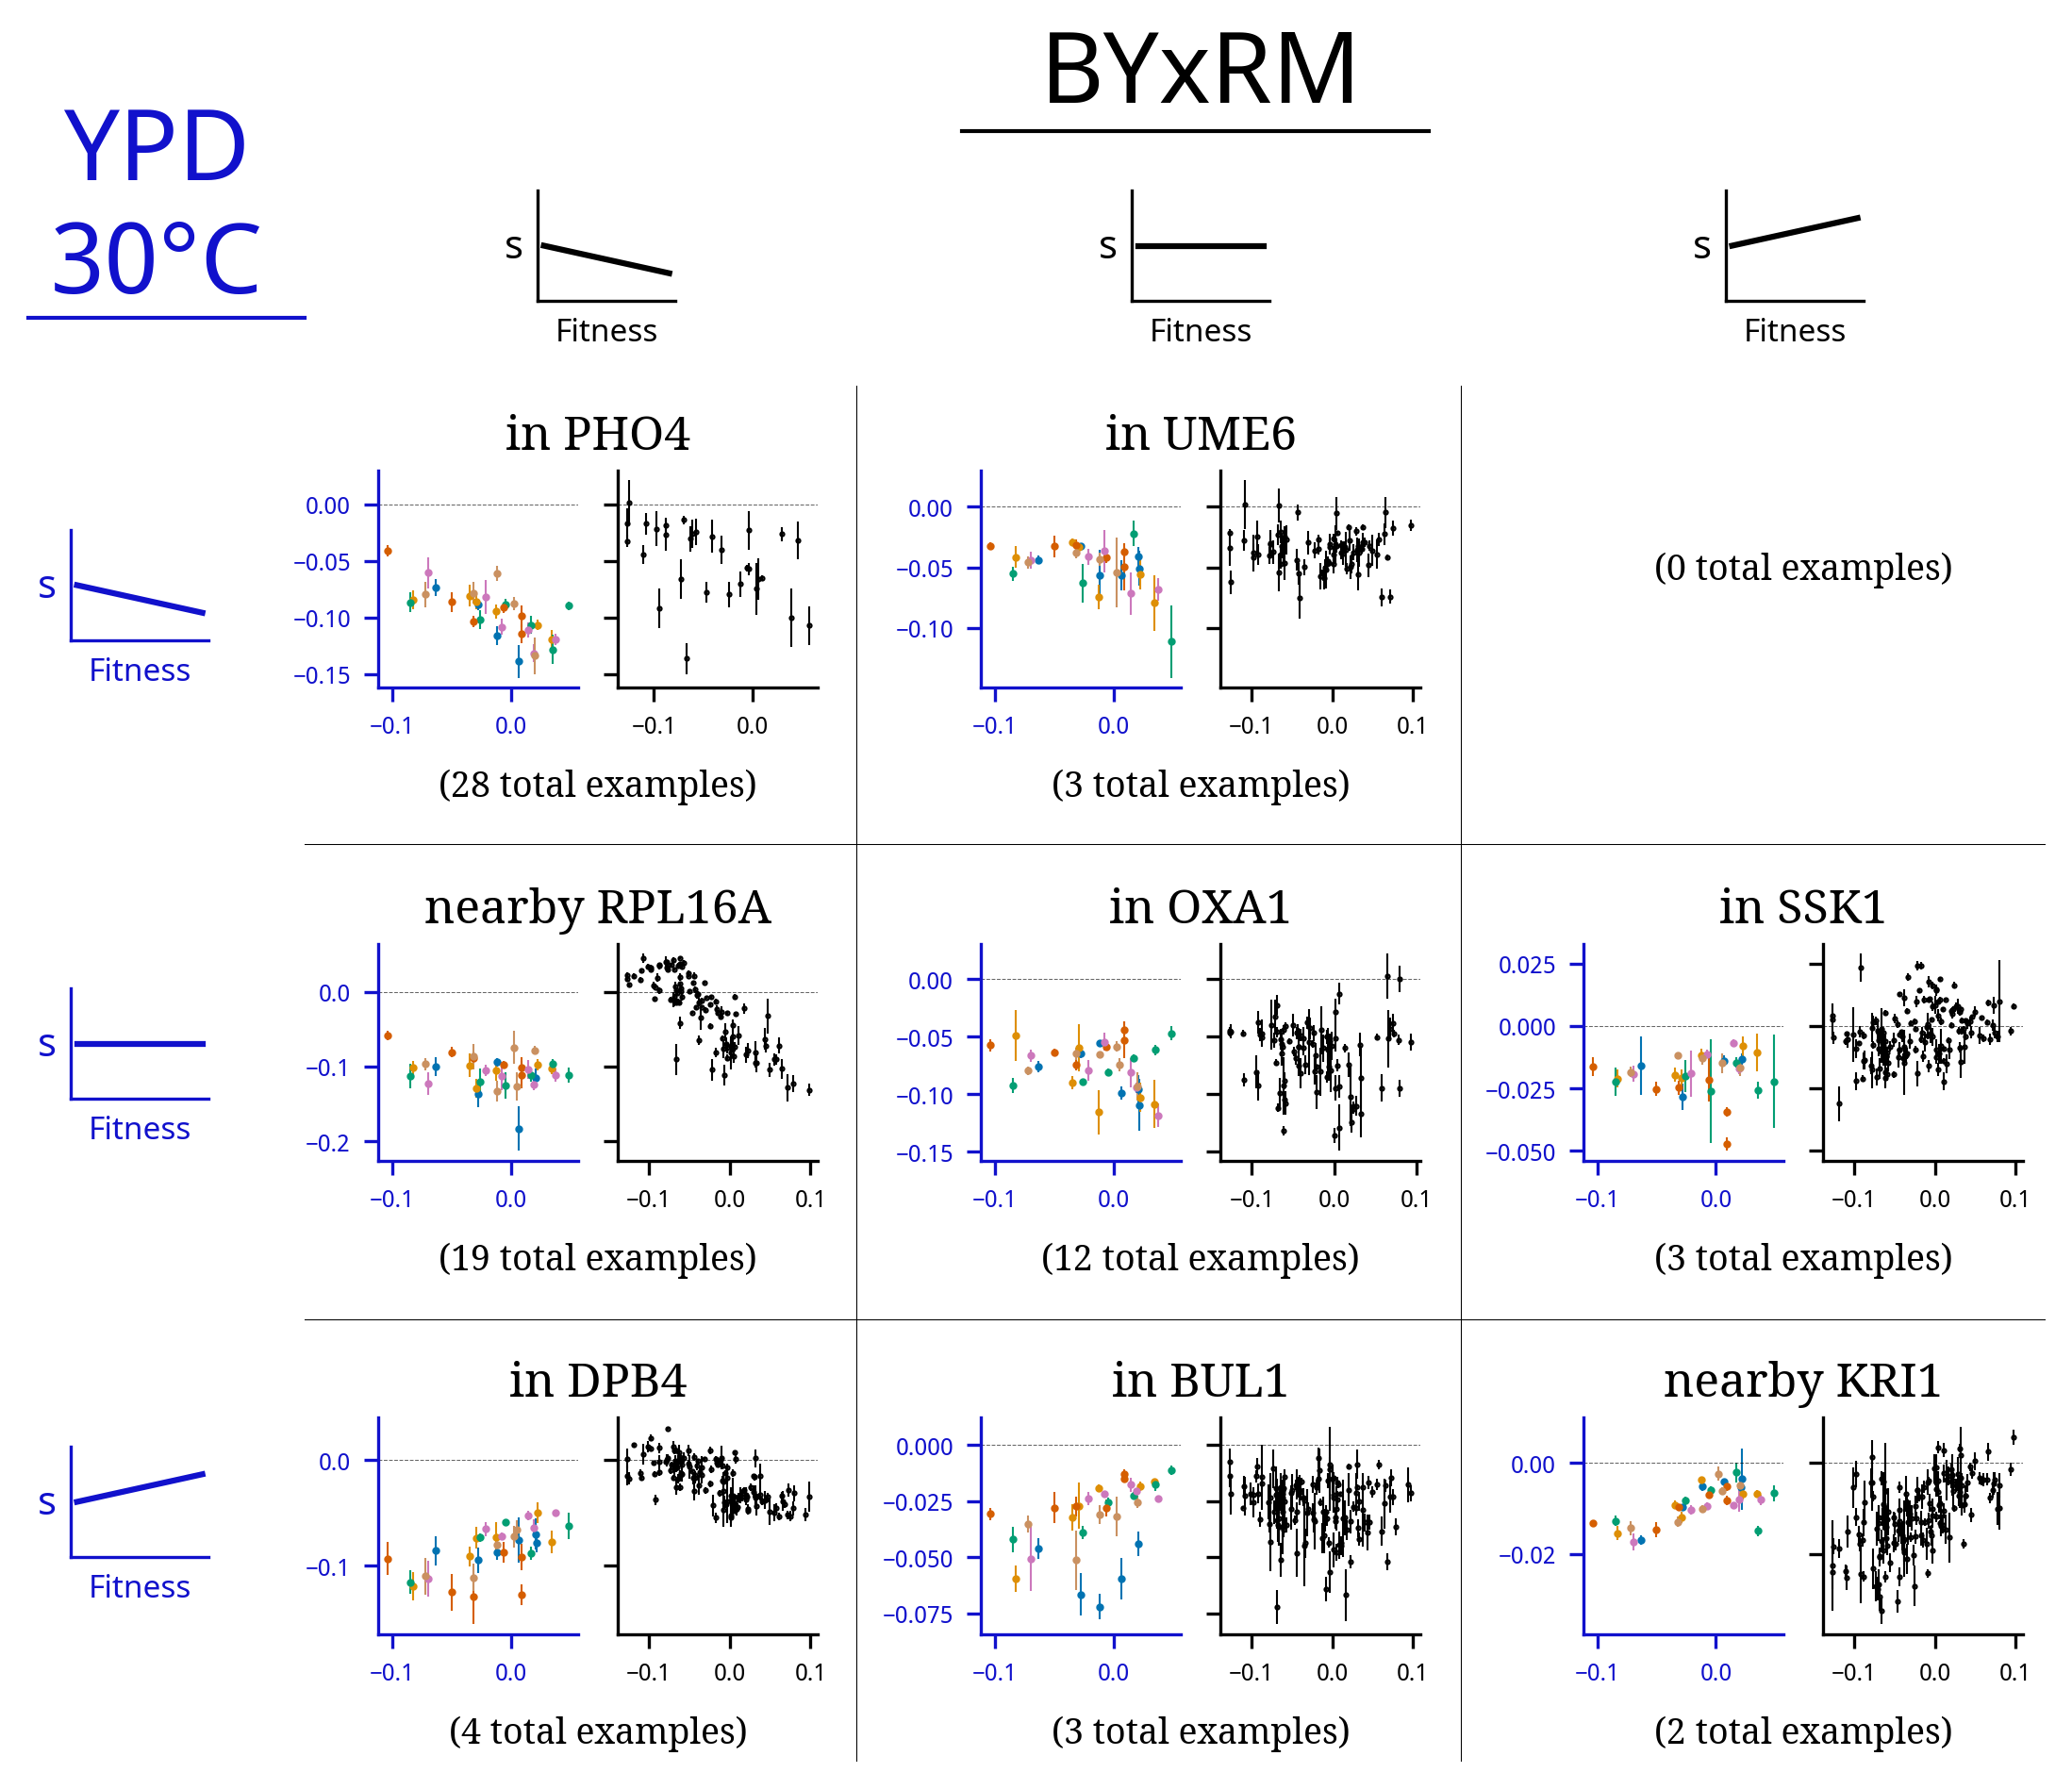

In [32]:
calls = ['-', 'NS', '+']
examples = {
    calls[0]+'_'+calls[0]: 'CAAGTTCGGCGAAAT', # in PHO4 *
    calls[0]+'_'+calls[1]: 'CGTCAAGACCTTCTA', # in UME6 *
    calls[0]+'_'+calls[2]: 'ACCACCGGTCCTGCC', # nearby UTP22 *
    calls[1]+'_'+calls[0]: 'GTGTGATTACTAAAT', # nearby RPL16A *
    calls[1]+'_'+calls[1]: 'ATCGTTGGCATTTGG', # in OXA1 *
    calls[1]+'_'+calls[2]: 'CCAGGATGTACCGCC', # in SSK1 * 
    calls[2]+'_'+calls[0]: 'AGAACATCATCTACA', # in DPB4 *
    calls[2]+'_'+calls[1]: 'CAAGGATCCCCGTAG', # in BUL1 *
    calls[2]+'_'+calls[2]: 'AGTGTATGATAATAT', # nearby KRI1 *
}
cross_plot('P1_YPD_30C', 'BYxRM', '#11C', 'k', 'YPD 30°C', 'BYxRM', examples, '../../Figures/supp_figs/Fitness_mediated_YPD_v_BYRM.png')

- - ['nearby RPL16A', 'in NOP16', 'in RPL16A', 'in OCA1', 'in FLC2', 'in ADE5,7', 'in MPC2', 'in RPL31B', 'nearby NCP1', 'nearby CCW12', 'in RPL2A', 'in RPL35B', 'in UBP3', 'nearby KRE6', 'in RPL31B', 'in SPT8']
1
NS - ['in CPR6', 'nearby OST4', 'in FUN30', 'in LAT1', 'nearby SFP1', 'nearby NUP157', 'in FUN30', 'in RTG1', 'in TRM9', 'in SIR4', 'in SLX8', 'in PHO4', 'in GPP1', 'in HOS4', 'in EBS1', 'in VAM6', 'in SCJ1', 'in STE24', 'in UBP1', 'in TRP2', 'in SLX5', 'nearby YLR264C-A', 'in CBS1', 'in STM1', 'in BRR1', 'in RSC30', 'in RPS14B', 'in SIR4']
1
NS NS ['in MME1', 'in BUL1', 'in PPM1', 'in RRP46', 'nearby MET4', 'in TRP2', 'in MAC1', 'in OXA1', 'nearby PDE2', 'in VPS38', 'in CSR1', 'in VPS36', 'nearby PAH1']
1
NS + ['nearby KRI1', 'in KAP123', 'nearby UTP22']
1
+ - ['in SLX8', 'in DPB4', 'in SUM1', 'in SIR3', 'in NOT3', 'in MSL1']
1
+ NS ['in EAF1', 'in COG8', 'in RGS2', 'nearby YOL085W-A']
1
+ + ['in SSK1', 'in MCK1']
1


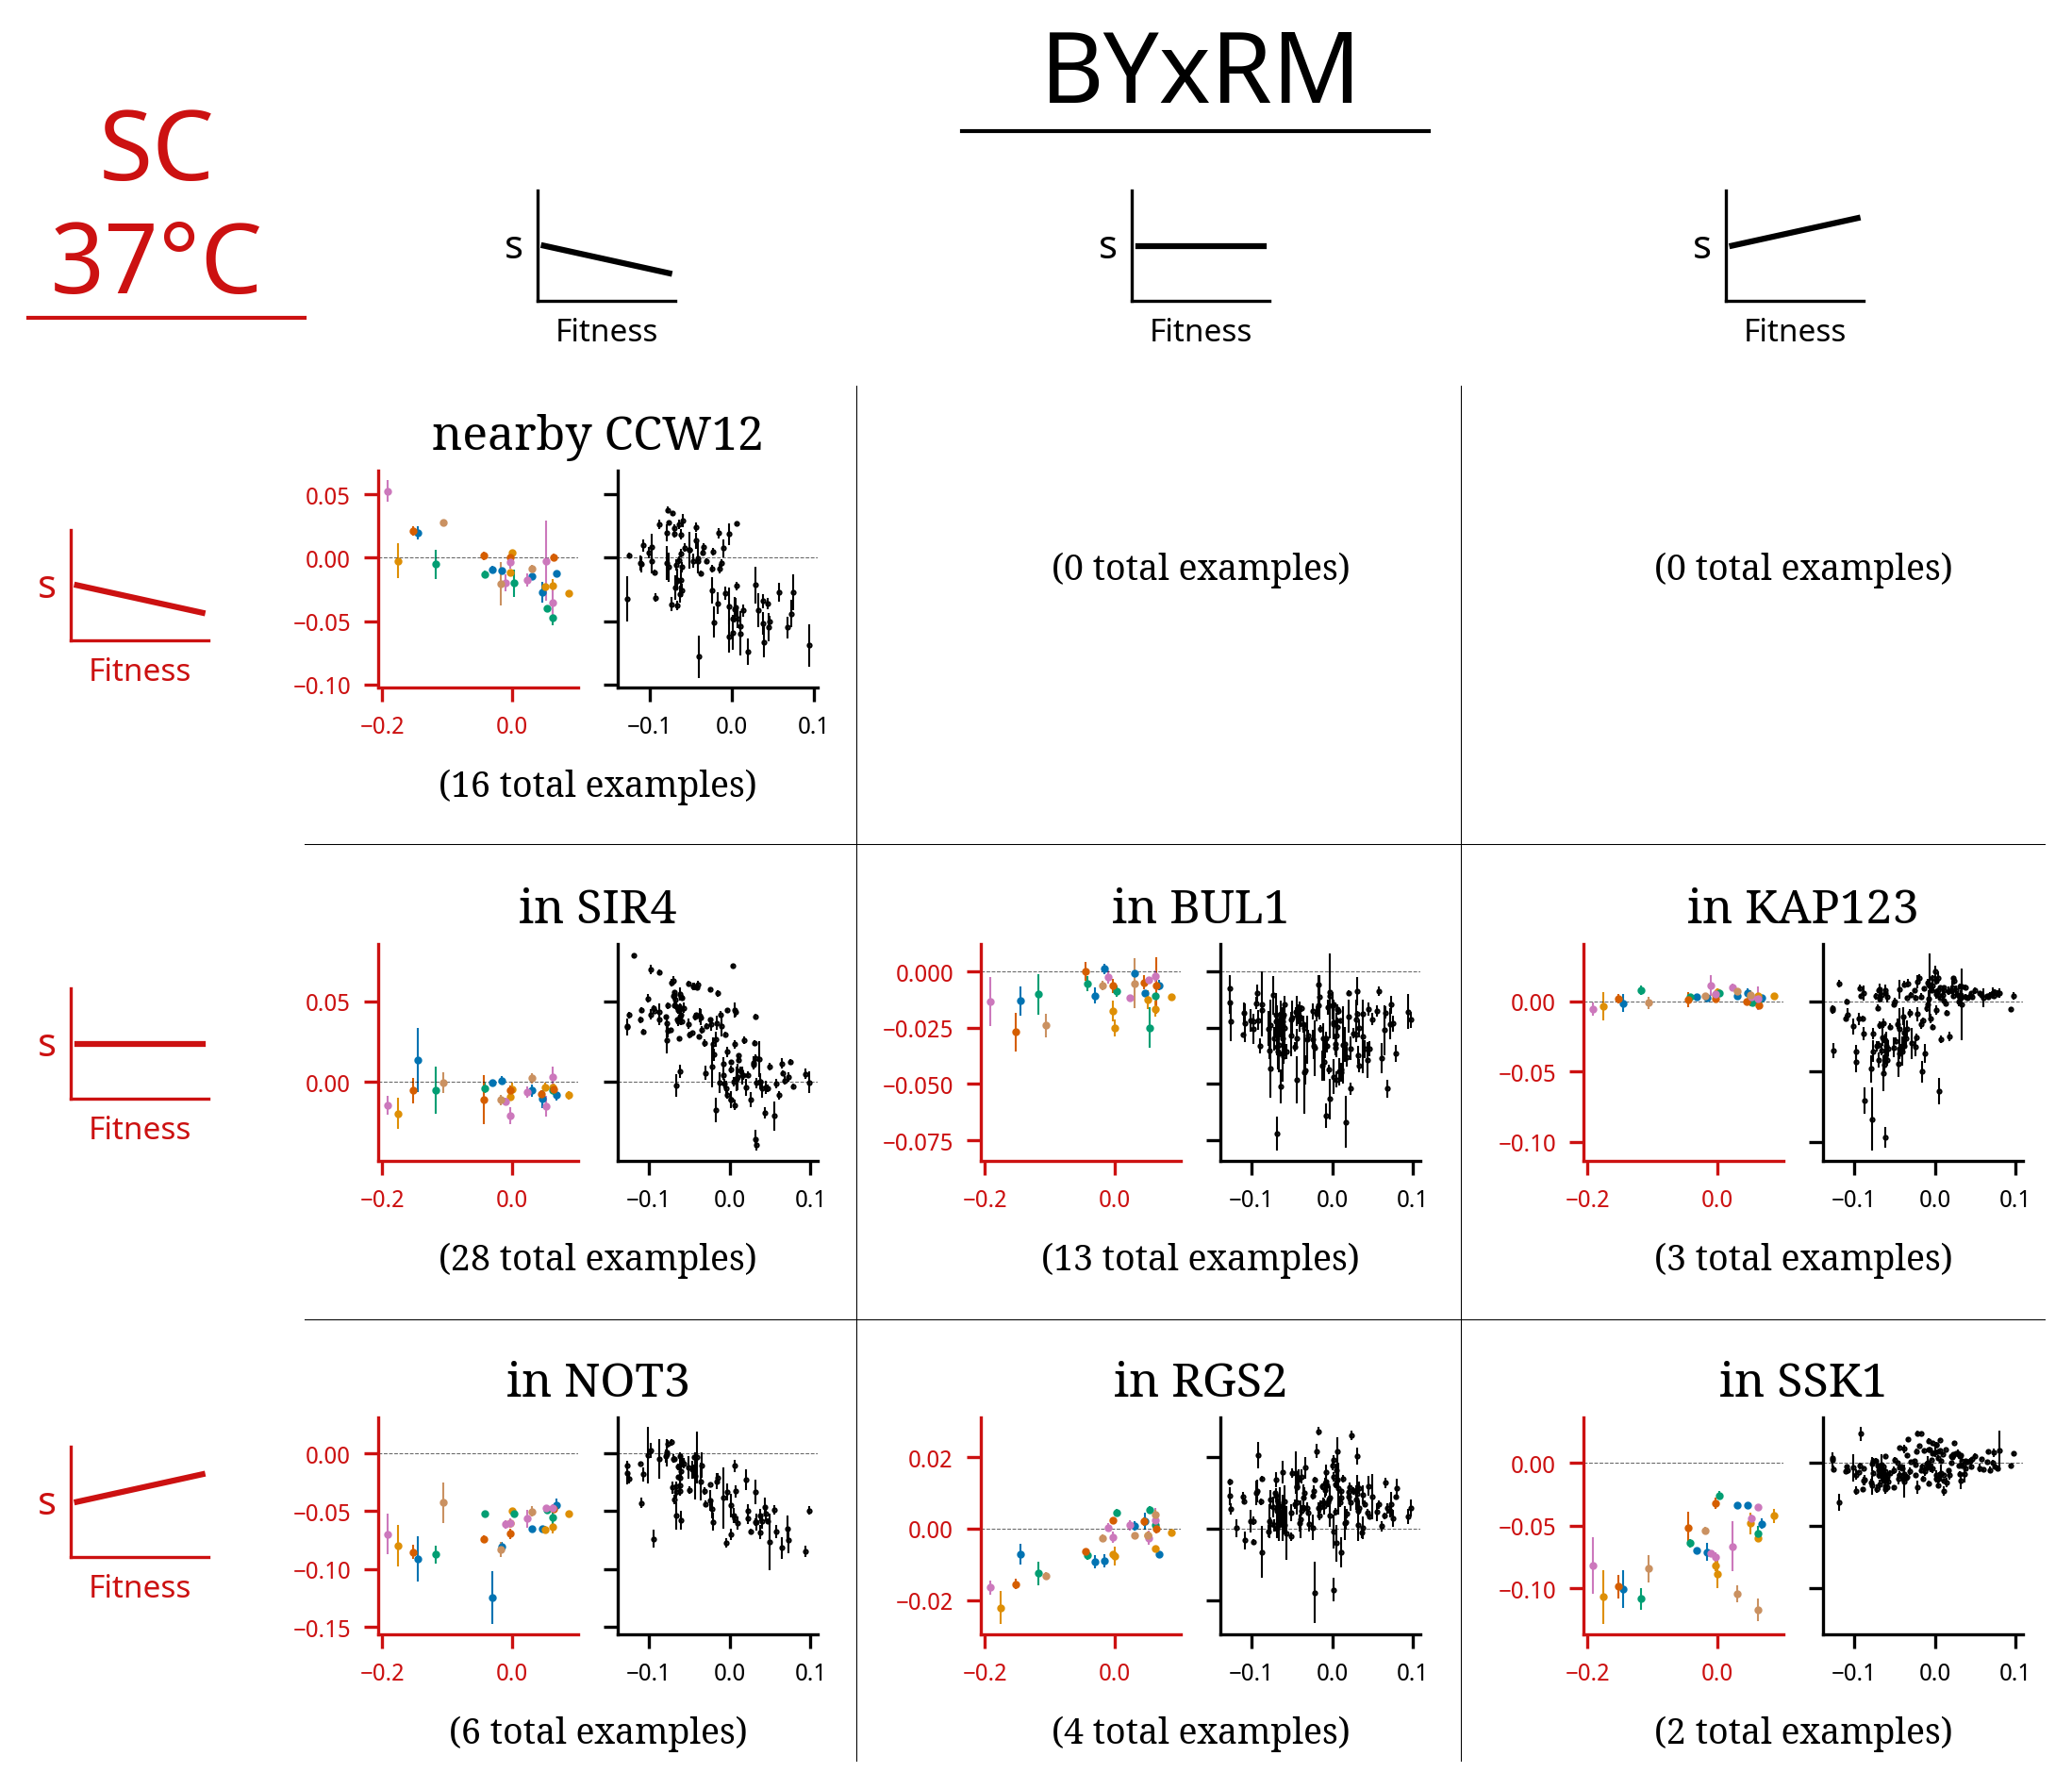

In [33]:
examples = {
    calls[0]+'_'+calls[0]: 'AGTTTATAAAAAATT', # nearby CCW12
    calls[0]+'_'+calls[1]: None, 
    calls[0]+'_'+calls[2]: 'ACCACCGGTCCTGCC', # nearby UTP22
    calls[1]+'_'+calls[0]: 'GTCACCGGCACTAAC', # in SIR4
    calls[1]+'_'+calls[1]: 'CAAGGATCCCCGTAG', # in BUL1
    calls[1]+'_'+calls[2]: 'CTACTTACAACGGAA', # in KAP123
    calls[2]+'_'+calls[0]: 'TGGAGTCTTTGTTGA', # in NOT3
    calls[2]+'_'+calls[1]: 'CTCGCTAATACTCCT', # in RGS2
    calls[2]+'_'+calls[2]: 'CCAGGATGTACCGCC', # in SSK1
}
cross_plot('P3_SC_37C', 'BYxRM', '#C11', 'k', 'SC 37°C', 'BYxRM', examples, '../../Figures/supp_figs/Fitness_mediated_SC37C_v_BYRM.png')

- - ['in NOP16', 'in RPL16A', 'in FUN30', 'in RPL31B', 'nearby YLR264C-A', 'nearby CCW12', 'in RPL2A', 'in RPL35B', 'nearby KRE6', 'in RPL31B']
1
- NS ['nearby OST4', 'in LAT1', 'in SPT8', 'in OCA1', 'in FLC2', 'in PHO4', 'in MPC2', 'nearby MET4', 'in PHO4', 'in RSC30', 'in SPT8']
1
- + ['in GPP1', 'in HOS4', 'in MAC1', 'nearby NCP1', 'in SCJ1', 'in STE24', 'in SLX5', 'nearby VMA7']
1
NS - ['nearby RPL16A', 'in CPR6', 'in FUN30', 'in RPS14B']
1
NS NS ['in COG8', 'in MME1', 'in SLX8', 'nearby SFP1', 'nearby NUP157', 'in TRM9', 'in SIR4', 'in PPM1', 'in ADE5,7', 'in SSK1', 'in SLX8', 'in EBS1', 'in TRP2', 'in VAM6', 'in SIR3', 'nearby YOL085W-A', 'in TRP2', 'nearby UTP22', 'in CSR1', 'nearby SRB2', 'in CBS1', 'in VPS36', 'nearby PAH1', 'in SIR4']
1
NS + ['in RGS2', 'in KAP123', 'in OXA1', 'nearby PDE2', 'in UBP1']
0
+ NS ['in EAF1', 'nearby KRI1', 'in NOT3', 'in STM1']
1
+ + ['in BUL1', 'in SUM1']
0


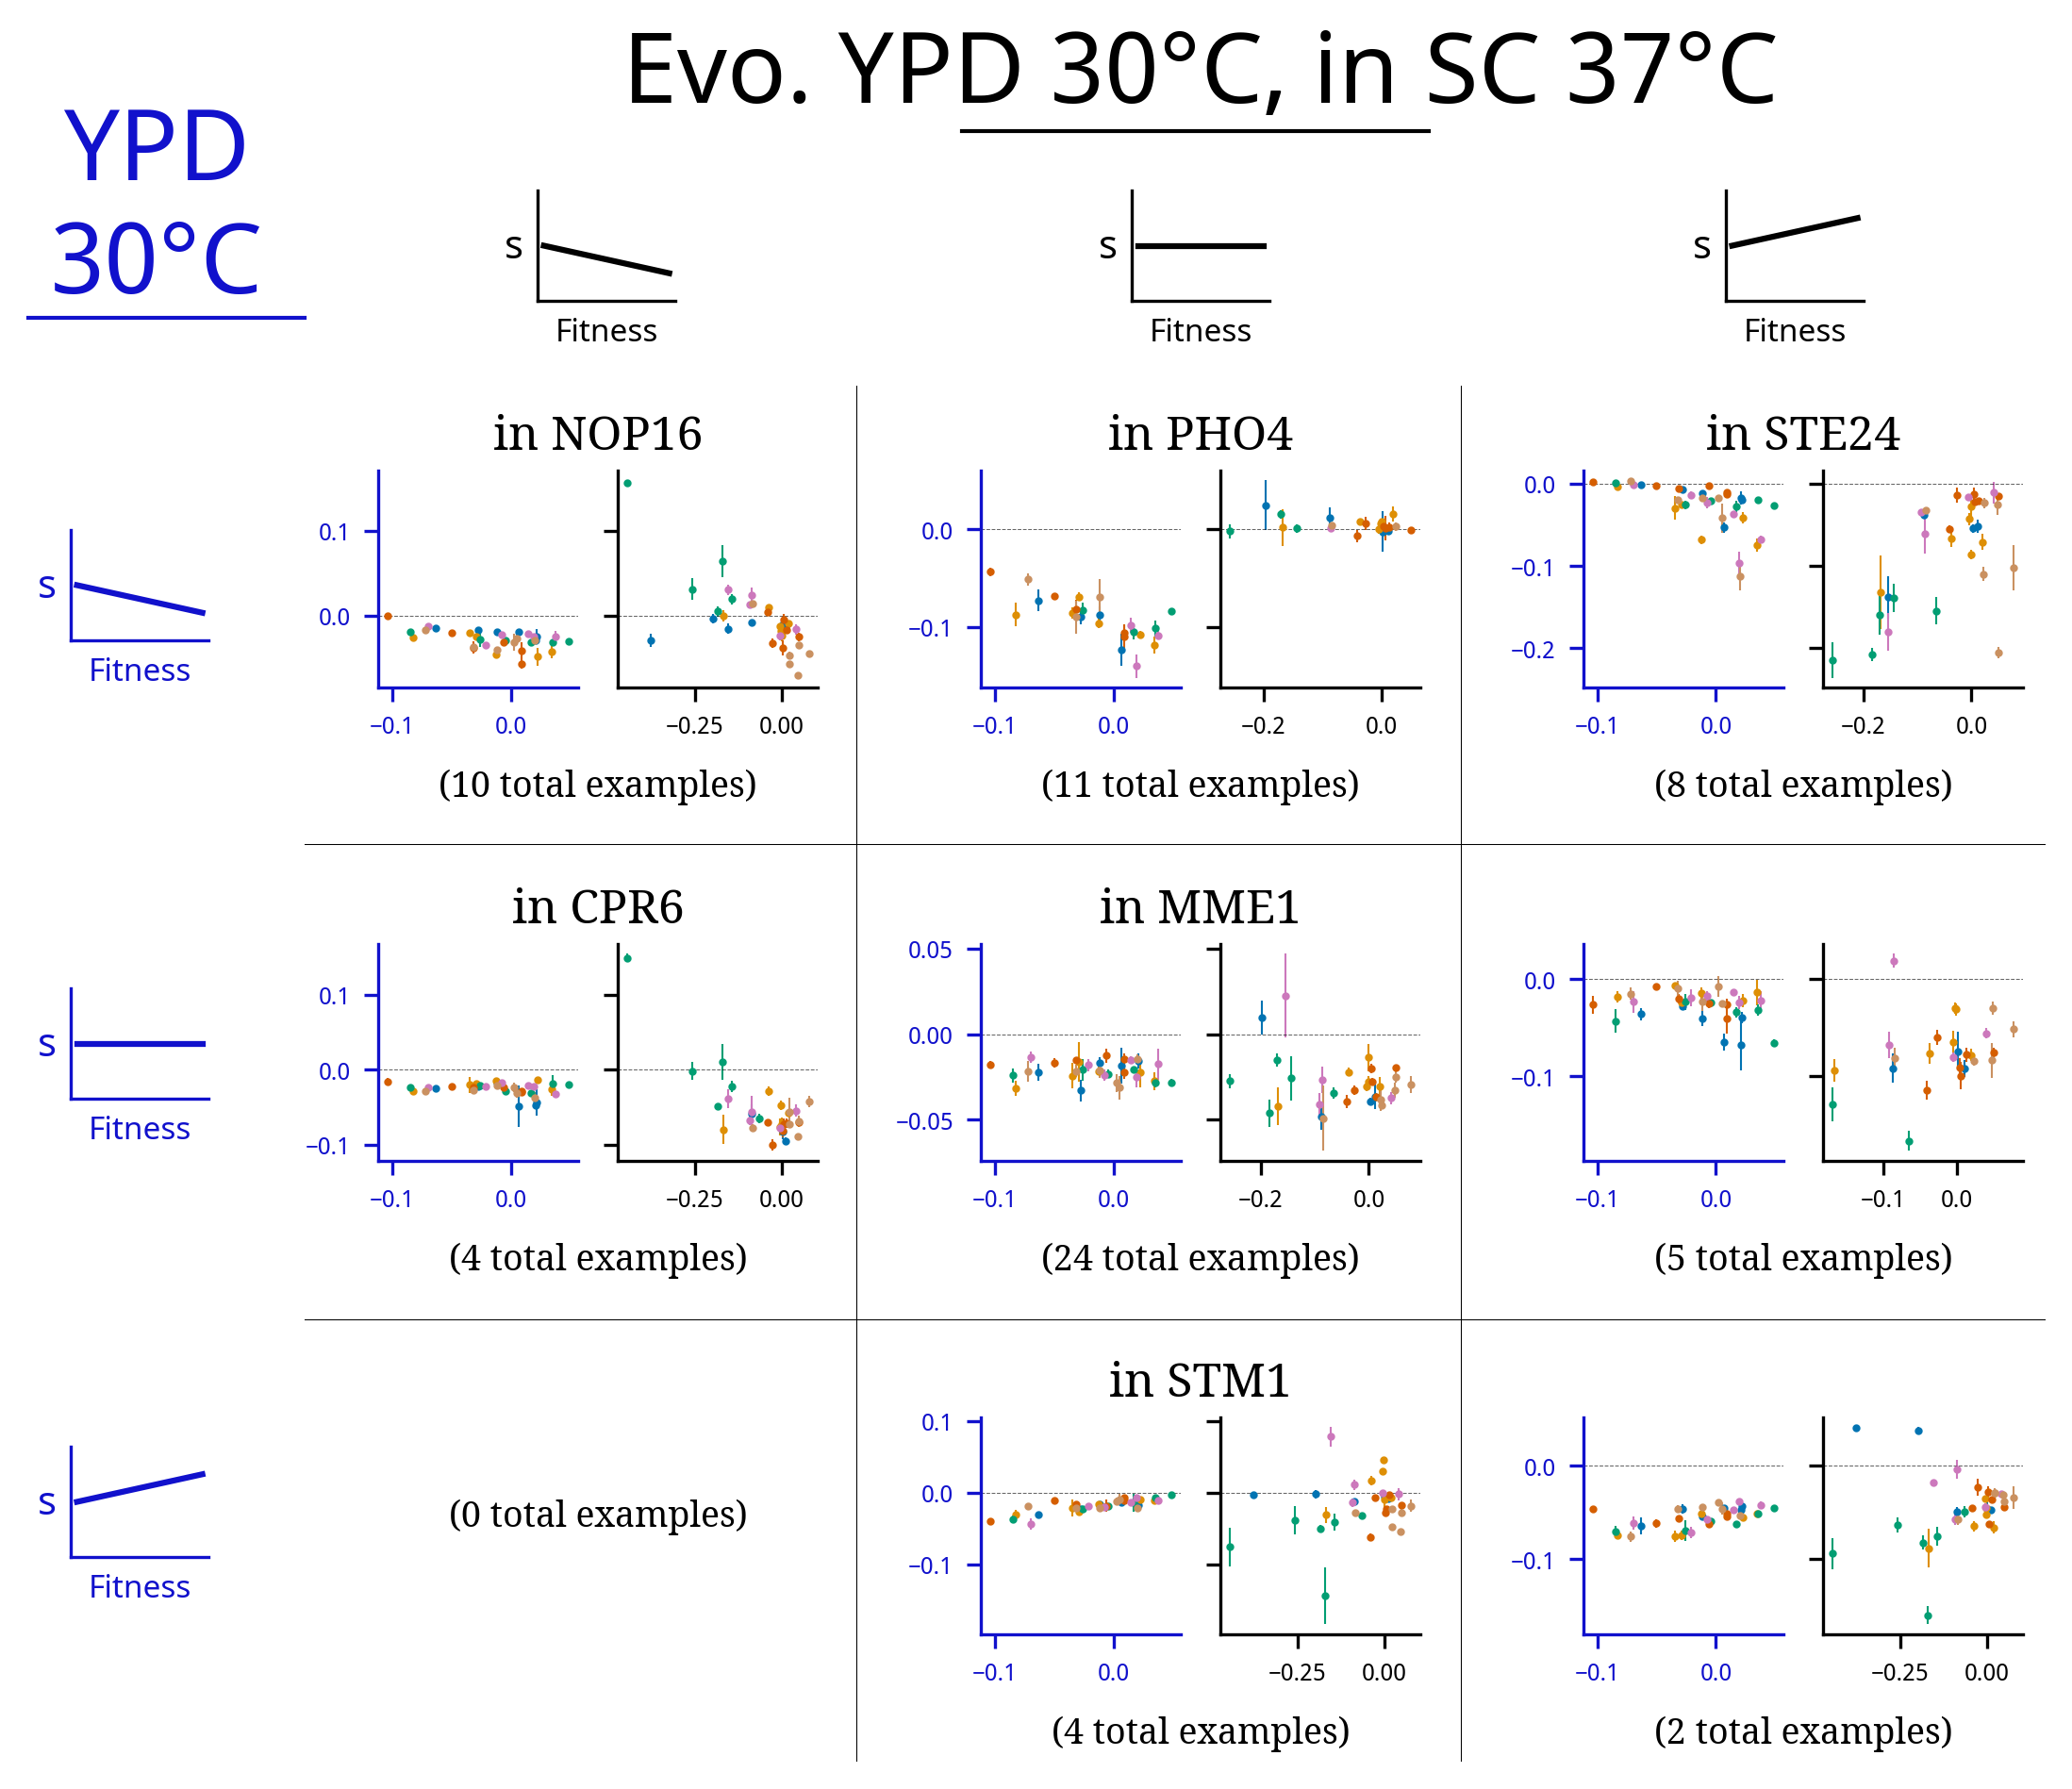

In [34]:
examples = {
    calls[0]+'_'+calls[0]: 'CCAACACAGGCTTCG', # in NOP16
    calls[0]+'_'+calls[1]: 'GGTGGAAGTAGCAGT', # in PHO4
    calls[0]+'_'+calls[2]: 'TCTTGGAGGTGAATG', # in STE24
    calls[1]+'_'+calls[0]: 'ATTATCAAGTGCCAG', # in CPR6
    calls[1]+'_'+calls[1]: 'GAACTCAGGTTCCAT', # in MME1
    calls[1]+'_'+calls[2]: 'CATTTATGGCTATCT', # in VAM6
    calls[2]+'_'+calls[1]: 'GTTGAACTGGTTGTT', # in STM1
    calls[2]+'_'+calls[2]: 'TGGAGTCTTTGTTGA'  # in NOT3
}

cross_plot('P1_YPD_30C', 'P1_SC_37C', '#11C', 'k', 'YPD 30°C', 'Evo. YPD 30°C, in SC 37°C', examples, '../../Figures/supp_figs/Fitness_mediated_YPD_v_P1SC37C.png')


- - ['nearby RPL16A', 'in NOP16', 'in RPL16A', 'in RPL31B', 'nearby CCW12', 'in RPL2A', 'in RPL35B', 'nearby KRE6', 'in RPL31B']
1
- NS ['in OCA1', 'in FLC2', 'in ADE5,7', 'in MPC2', 'in SPT8']
1
- + ['nearby NCP1', 'nearby VMA7']
1
NS - ['in CPR6', 'in FUN30', 'in FUN30', 'nearby YLR264C-A', 'in RPS14B']
0
NS NS ['nearby OST4', 'in MME1', 'in LAT1', 'nearby SFP1', 'nearby NUP157', 'in TRM9', 'in SIR4', 'in PPM1', 'nearby KRI1', 'in RRP46', 'in SLX8', 'in PHO4', 'in EBS1', 'nearby MET4', 'in TRP2', 'in VAM6', 'in TRP2', 'nearby UTP22', 'in CSR1', 'in CBS1', 'in VPS36', 'in STM1', 'nearby PAH1', 'in RSC30', 'in SIR4']
0
NS + ['in BUL1', 'in KAP123', 'in GPP1', 'in HOS4', 'in MAC1', 'in OXA1', 'nearby PDE2', 'in SCJ1', 'in STE24', 'in UBP1', 'in SLX5']
1
+ NS ['in EAF1', 'in COG8', 'in SLX8', 'in SSK1', 'in SIR3', 'nearby YOL085W-A', 'in NOT3', 'nearby SRB2', 'in MSL1']
1
+ + ['in RGS2', 'in SUM1']
0


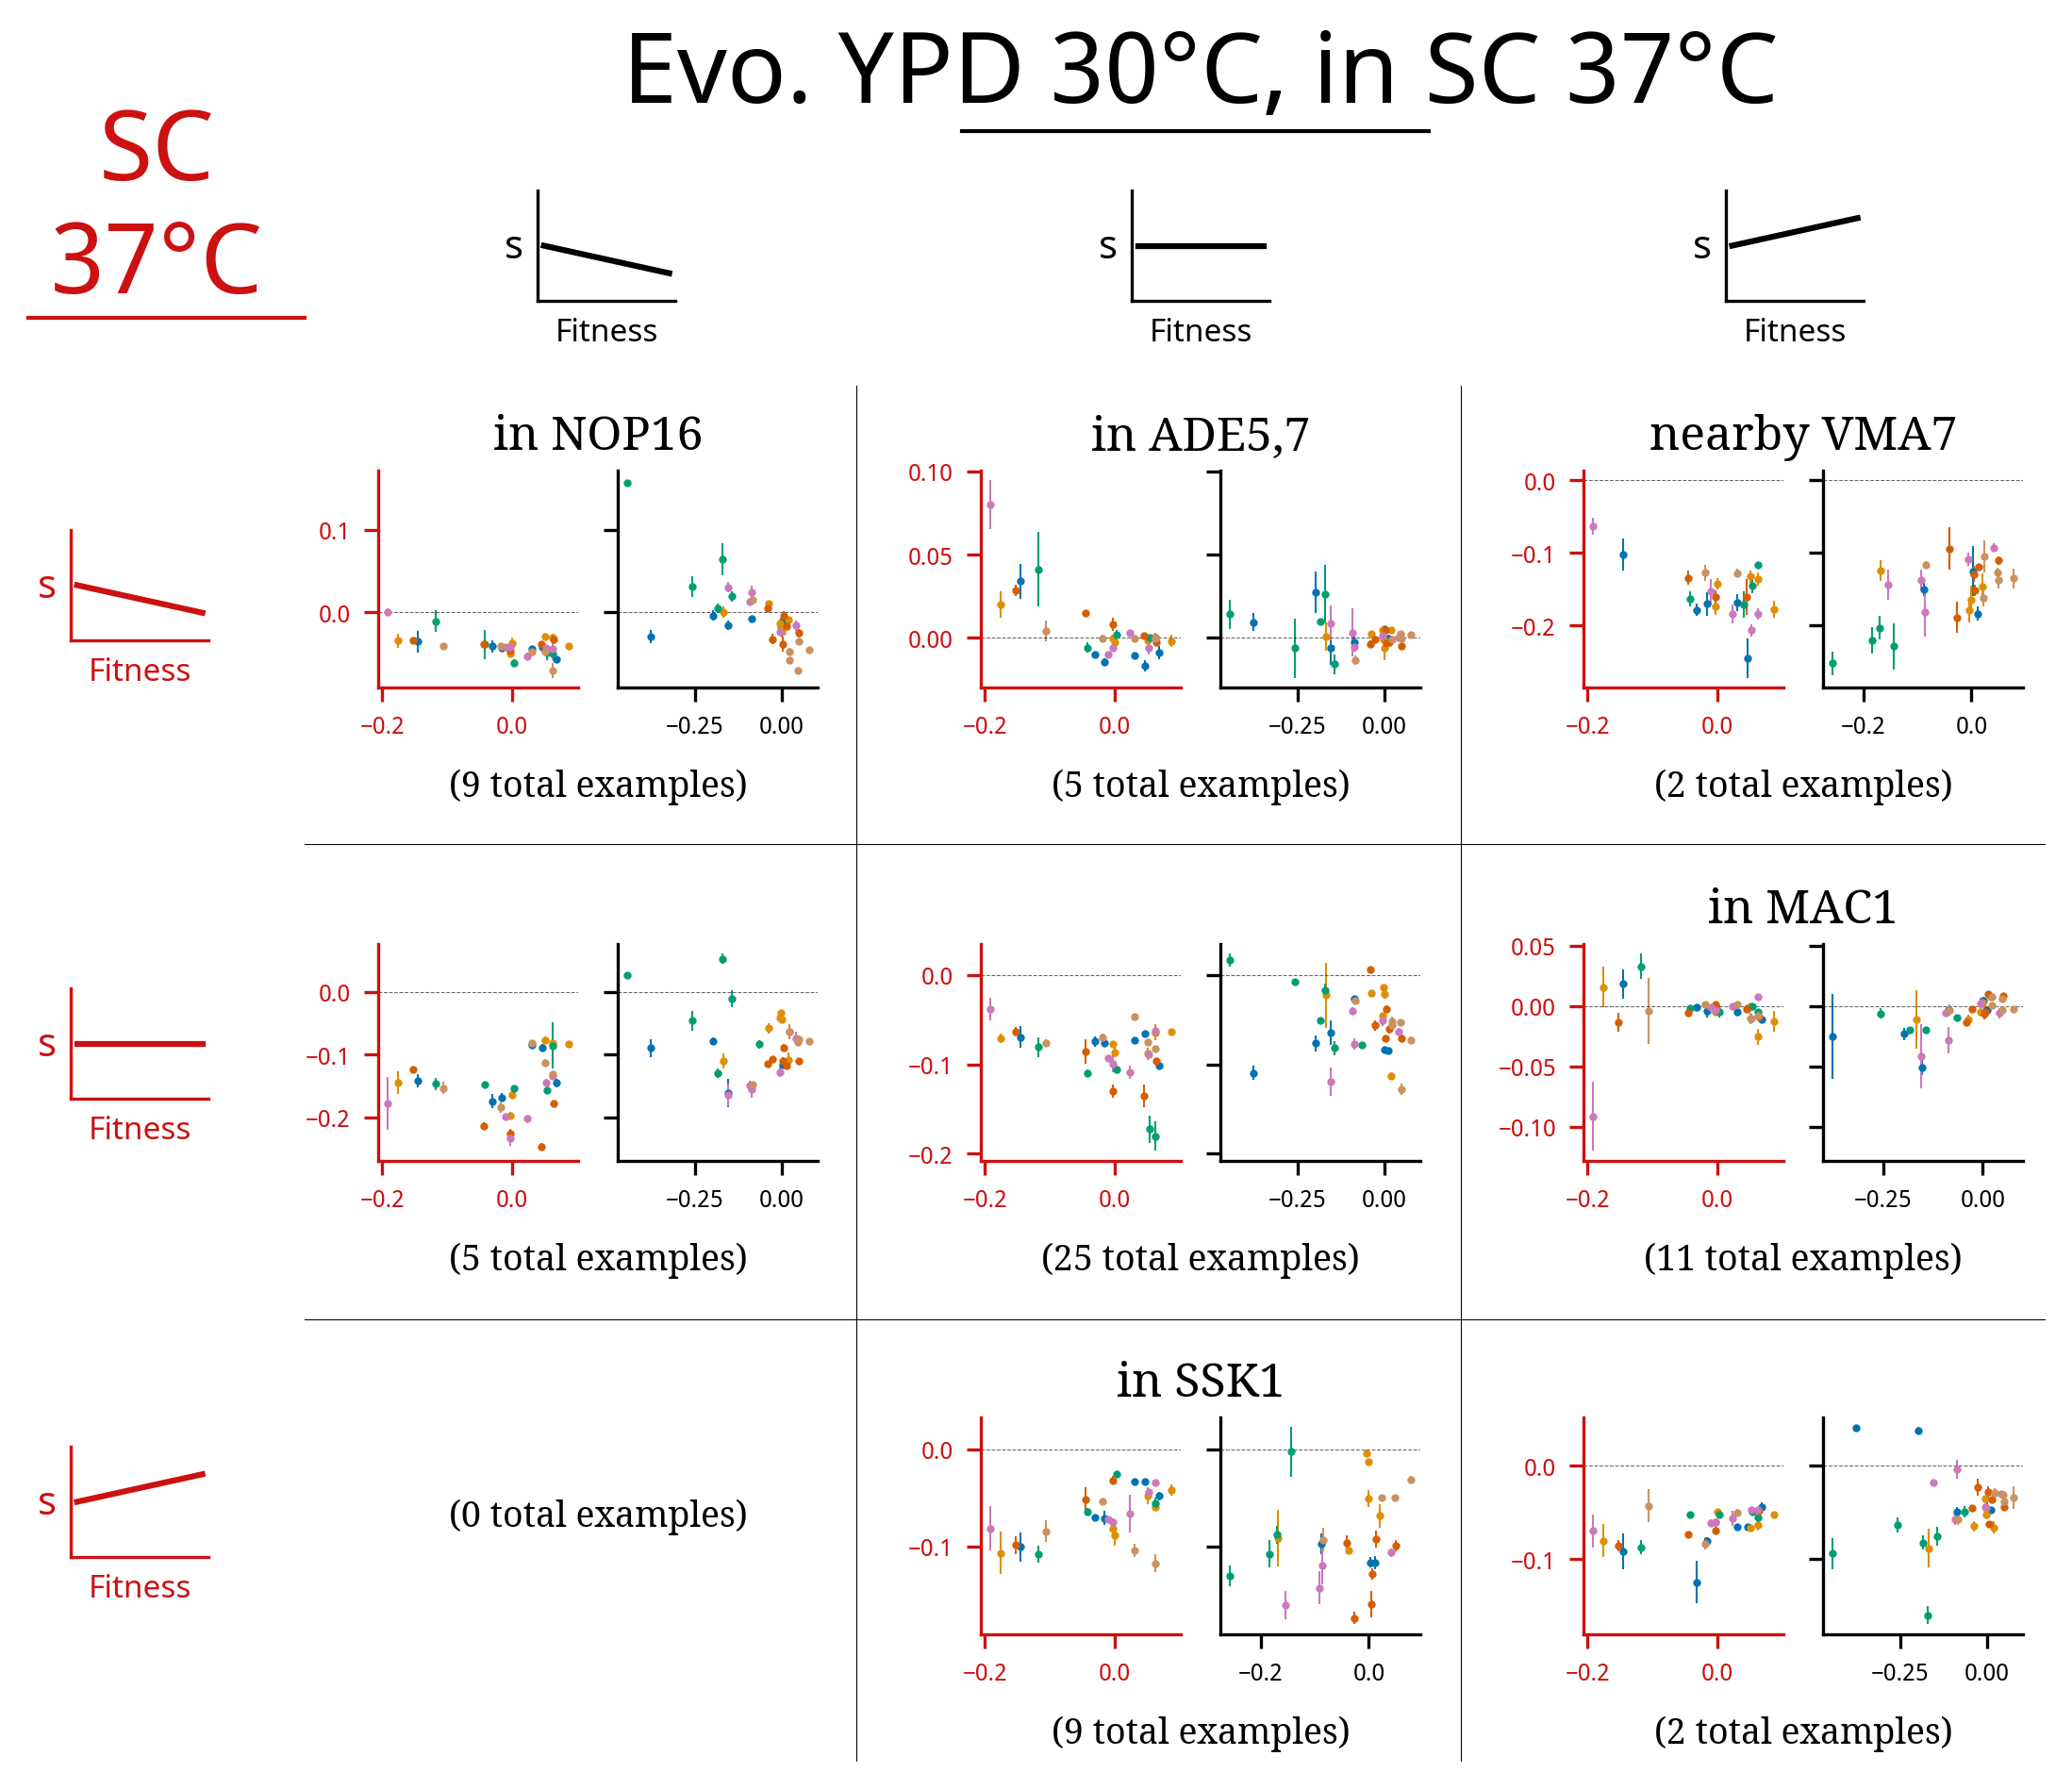

In [35]:
examples = {
    calls[0]+'_'+calls[0]: 'CCAACACAGGCTTCG', # in NOP16
    calls[0]+'_'+calls[1]: 'AGATTCATCCCATGG', # in ADE5,7
    calls[0]+'_'+calls[2]: 'GTTTGTTTTGGGAAA', # nearby VMA7
    calls[1]+'_'+calls[0]: 'CTAAGCAGTCTTCTC', # in LAT1
    calls[1]+'_'+calls[1]: 'AGAAGACGACGATGA', # in OCA1
    calls[1]+'_'+calls[2]: 'CATATGCATTCCTTG', # in MAC1
    calls[2]+'_'+calls[0]:  None,
    calls[2]+'_'+calls[1]: 'CCAGGATGTACCGCC', # in SSK1
    calls[2]+'_'+calls[2]: 'TGGAGTCTTTGTTGA'  # in NOT3
}
cross_plot('P3_SC_37C','P1_SC_37C',  '#C11', 'k', 'SC 37°C', 'Evo. YPD 30°C, in SC 37°C', examples, '../../Figures/supp_figs/Fitness_mediated_P1SC37C_v_SC37.png')

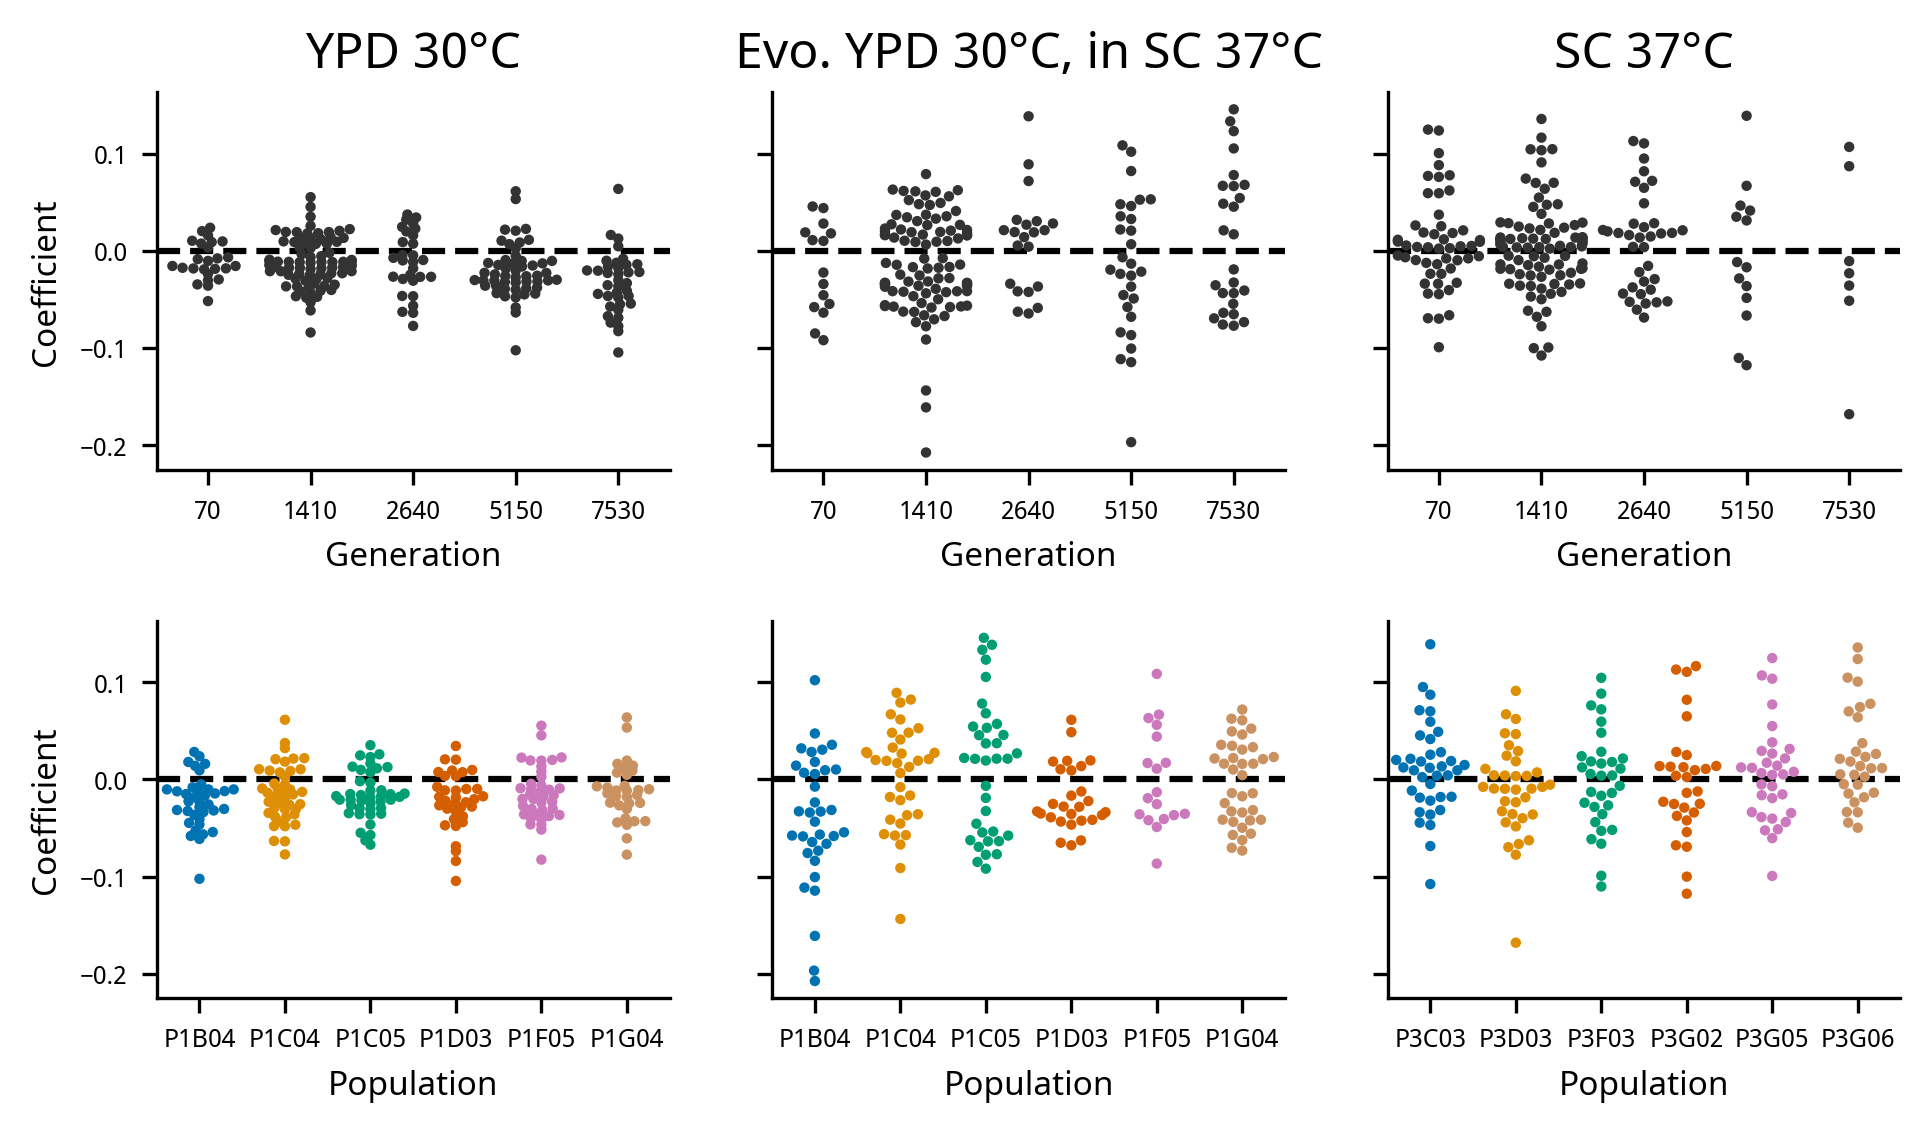

In [36]:
def coeff_breakdown(cond, subs, model):
    mat = []
    for i in np.array(edge_stats[pd.notnull(edge_stats[cond+'_'+model+'_Params'])][[cond+'_'+model+'_Params', cond+'_'+model+'_Coeffs']]):
        if model == 'IM':
            p, c = i[0].split(';'), i[1].split(';')
        elif model == 'FM':
            fps = str(i[0]).split(';')
            FM_cs = str(i[1]).split(';')
            c = [float(FM_cs[i]) for i in range(len(FM_cs)) if fps[i]!='Fitness_sub_70']
            p = [fps[i] for i in range(len(FM_cs)) if fps[i]!='Fitness_sub_70']
        for j in range(1, len(p)):
            mat.append([p[j], float(c[j])])

    all_coeffs = pd.DataFrame(mat, columns=['Param', 'Coeff'])
    all_coeffs['Pop'] = all_coeffs['Param'].str.split('_').str[1]
    all_coeffs['Gen'] = all_coeffs['Param'].apply(lambda p: int(str(p).split('_')[2]))
    sns.swarmplot(data=all_coeffs, x='Pop', y='Coeff', hue='Pop', palette=color_map, order=cond_pops[cond.split('_')[0]], ax=subs[1], s=2.5)
    sns.swarmplot(data=all_coeffs, x='Gen', y='Coeff', color='#333333', ax=subs[0], s=2.5)
    subs[1].get_legend().remove()
    

fig, subps = pl.subplots(2, 3, figsize=(7.5, 4), dpi=300, sharey=True)
pl.subplots_adjust(hspace=0.4)
coeff_dfs = dict()
cond_plus = ['P1_YPD_30C', 'P1_SC_37C', 'P3_SC_37C']
for i in range(3):
    subs = [subps[0][i], subps[1][i]]
    for j in range(2):
        subs[j].axhline(y=0, c='k', linestyle='dashed')
        subs[j].tick_params(labelsize=6)
    
    coeff_breakdown(cond_plus[i], subs, 'IM')
    subs[0].set_title(cond_to_title[cond_plus[i]])
    subs[0].set_xlabel('Generation', fontsize=8)
    subs[1].set_xlabel('Population', fontsize=8)
    if i == 0:
        subs[0].set_ylabel('Coefficient', fontsize=8)
        subs[1].set_ylabel('Coefficient', fontsize=8)
    else:
        subs[0].set_ylabel('')
        subs[1].set_ylabel('')
        
#subps[1][0].legend(frameon=False, bbox_to_anchor=(1.7,-0.3), ncol=3, fontsize=7)
#subps[1][1].get_legend().remove()
#subps[1][2].legend(frameon=False, bbox_to_anchor=(1.2,-0.3), ncol=3, fontsize=7)

sns.despine()
fig.savefig('../../Figures/supp_figs/Coeff_breakdown.png', background='transparent', bbox_inches='tight', pad_inches=0.1)


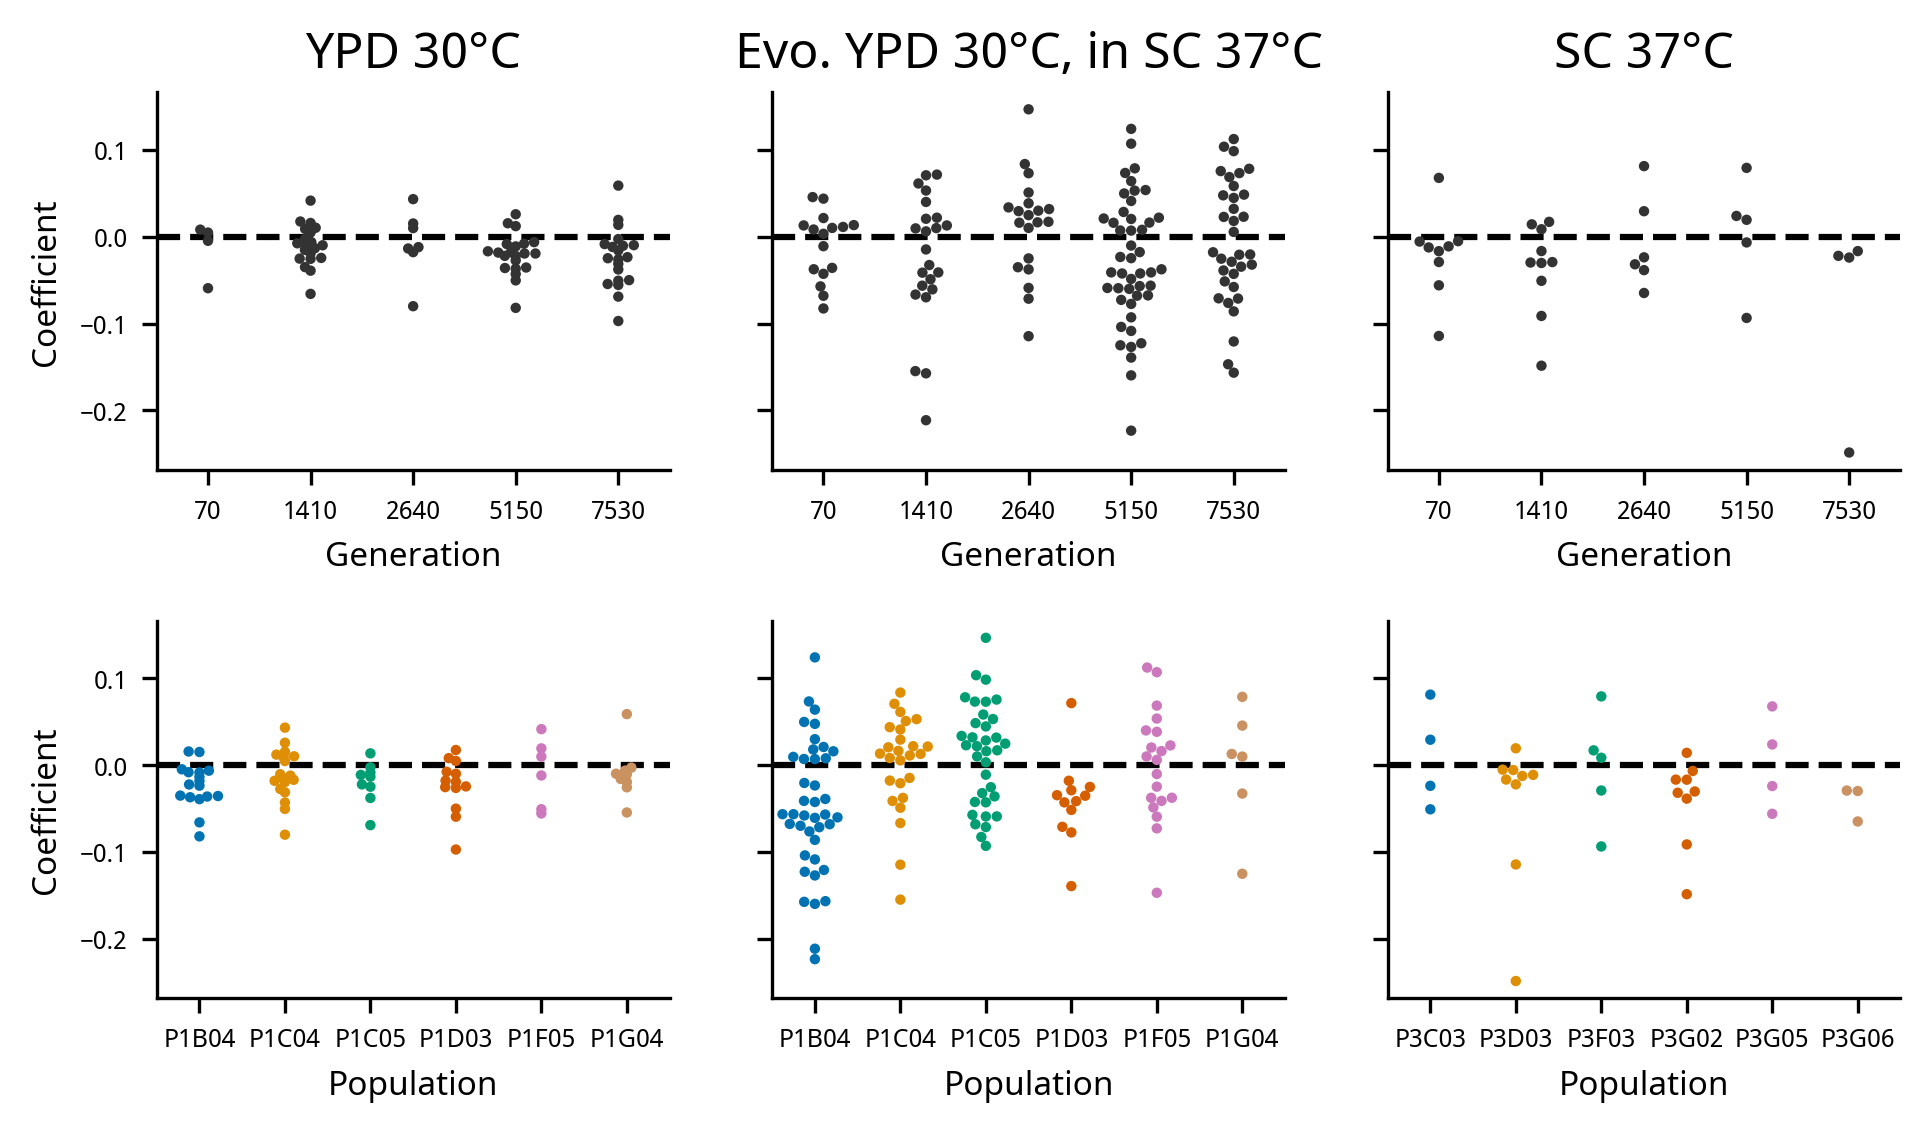

In [37]:
fig, subps = pl.subplots(2, 3, figsize=(7.5, 4), dpi=300, sharey=True)
pl.subplots_adjust(hspace=0.4)
for i in range(3):
    subs = [subps[0][i], subps[1][i]]
    for j in range(2):
        subs[j].axhline(y=0, c='k', linestyle='dashed')
        subs[j].tick_params(labelsize=6)
    
    coeff_breakdown(cond_plus[i], subs, 'FM')
    subs[0].set_title(cond_to_title[cond_plus[i]])
    subs[0].set_xlabel('Generation', fontsize=8)
    subs[1].set_xlabel('Population', fontsize=8)
    if i == 0:
        subs[0].set_ylabel('Coefficient', fontsize=8)
        subs[1].set_ylabel('Coefficient', fontsize=8)
    else:
        subs[0].set_ylabel('')
        subs[1].set_ylabel('')
        
#subps[1][0].legend(frameon=False, bbox_to_anchor=(1.7,-0.3), ncol=3, fontsize=7)
#subps[1][1].get_legend().remove()
#subps[1][2].legend(frameon=False, bbox_to_anchor=(1.2,-0.3), ncol=3, fontsize=7)

sns.despine()
fig.savefig('../../Figures/supp_figs/Coeff_breakdown_FM.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

In [42]:
e2g = {i[0]:i[1] for i in np.array(edge_stats[['Edge', 'Gene_Use']])}

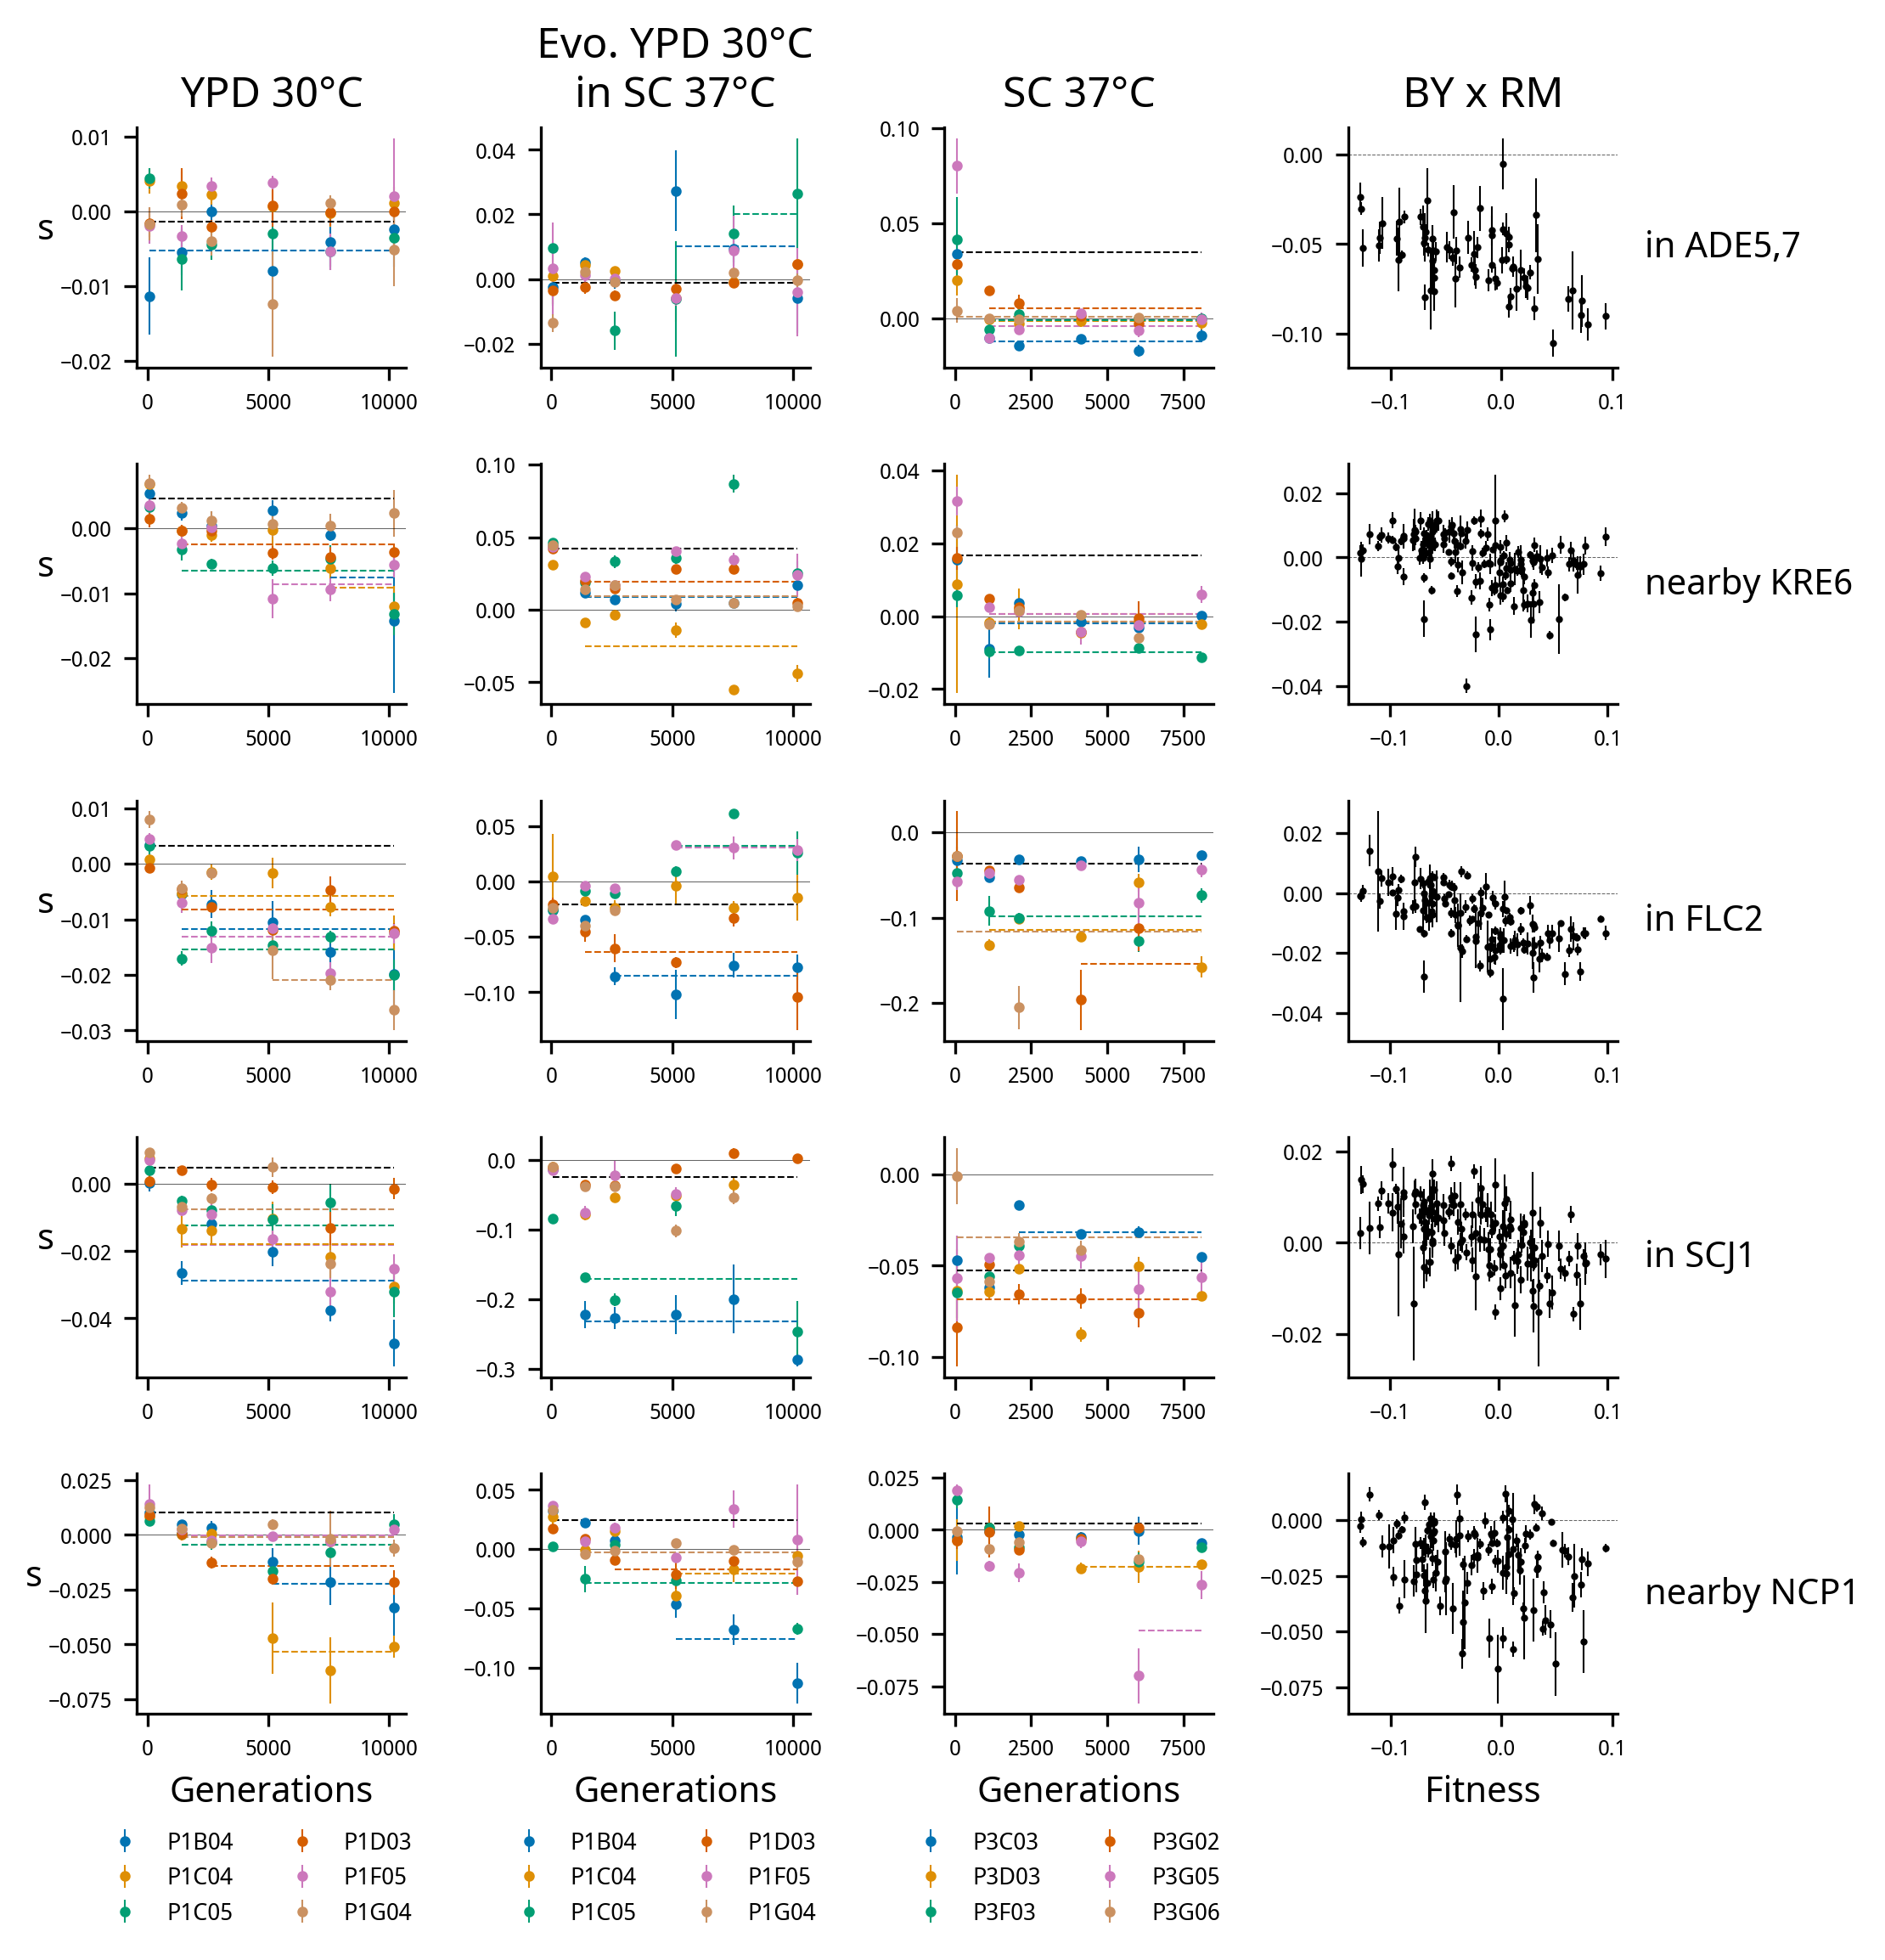

In [43]:
def plot_one_det(sub, cond, edge, model, axis_color, title_cond=True, ms=2, xlabel=True, title_at_all=True):
    td = vtn_s[(vtn_s['Edge']==edge) & (vtn_s['Cond']==cond) & (vtn_s['num_cbcs']>=5)]
    sub.axhline(0, color='k', linewidth=0.25, alpha=0.6)
    xvar = {'FM': 'Fitness', 'IM': 'Gen', 'IM2': 'Gen'}[model]
    for pop in cond_pops[cond.split('_')[0]]:
        ttd = td[td.Pop==pop].sort_values('Gen')
        if xvar == 'Gen':
            gen_rec = [gen_fixer[g][cond.split('_')[0]] for g in ttd['Gen']]
            sub.errorbar(x=gen_rec, y=ttd['s'], yerr=ttd['stderr'], linestyle='', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
        else:
            sub.errorbar(x=ttd[xvar], y=ttd['s'], yerr=ttd['stderr'], linestyle='', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
    if xlabel: 
        sub.set_xlabel({'Gen': 'Generations', 'Fitness': 'Fitness'}[xvar], fontsize=7)
    gene = edge_stats[edge_stats.Edge==edge].iloc[0]['Gene_Use']
    if title_cond:
        sub.set_title(cond_to_title[cond] + '\n' + gene, fontsize=7, y=0.95)
    elif title_at_all:
        sub.set_title(gene, fontsize=7, y=0.95)
    
    #sub.set_ylim([-0.15, 0.1])
    sub.tick_params(which='both', labelsize=6, colors=axis_color)
    sub.spines['bottom'].set_color(axis_color)
    sub.spines['left'].set_color(axis_color)
    #fit lines
    fit = edge_stats[edge_stats.Edge==edge].iloc[0]
    if pd.notnull(fit[cond+'_'+model+'_Params']):
        params = fit[cond+'_'+model+'_Params'].split(';')
        cs = fit[cond+'_'+model+'_Coeffs'].split(';')
        coeffs = {params[i]: float(cs[i]) for i in range(len(params))}
        if model == 'IM': 
            coeffs['Fitness_sub_70'] = 0
            coeffs['Intercept'] = td['g70_s'].iloc[0]
        elif model == 'FM':
            coeffs['Intercept'] = td['g70_s'].iloc[0]-g70_fits[cond]*coeffs['Fitness_sub_70']
        if xvar == 'Gen':
            x_rec = [gen_fixer[g][cond.split('_')[0]] for g in td['Gen']]
        else:
            x_rec = td[xvar]
        xlims = [np.min(x_rec), np.max(x_rec)]
        sub.plot(xlims, [i*coeffs['Fitness_sub_70']+coeffs['Intercept'] for i in xlims], c='k', linestyle='dashed', lw=0.5)
        for coef in [c for c in coeffs if c not in ['Fitness_sub_70', 'Intercept', 'dummy']]:
            if xvar == 'Gen':
                xlims[0] = np.min([gen_fixer[g][cond.split('_')[0]] for g in td[(td['Pop']==coef.split('_')[1]) & (td['Gen']>=int(coef.split('_')[-1]))][xvar]])
            else:
                xlims[0] = np.min(td[(td['Pop']==coef.split('_')[1]) & (td['Gen']>=int(coef.split('_')[-1]))][xvar])
            sub.plot(xlims, [i*coeffs['Fitness_sub_70']+coeffs['Intercept']+coeffs[coef] for i in xlims], c=color_map[coef.split('_')[1]], linestyle='dashed', lw=0.5)

            
def plot_one_byrm2(sub, edge, axis_color):
    ttd = byrm_s[(byrm_s['Edge']==edge) & (byrm_s['num_cbcs']>=5)]
    sub.axhline(0, linestyle='dashed', color='k', linewidth=0.25, alpha=0.6)
    sub.errorbar(x=ttd['Fitness'], y=ttd['s'], yerr=ttd['stderr'], linestyle='', marker='.', markersize=2, linewidth=0.5, color='k')
    sub.tick_params(which='both', labelsize=6, colors=axis_color)
    sub.spines['bottom'].set_color(axis_color)
    sub.spines['left'].set_color(axis_color)
    

def plot_6(edges, outname, model, sharey='row'):
    fig, subps = pl.subplots(6, 4, figsize=(7.5, 10), dpi=300, sharey=sharey)
    if sharey == 'row':
        pl.subplots_adjust(hspace=0.4)
    else:
        pl.subplots_adjust(hspace=0.4, wspace=0.5)
    rc = 0
    subps[0][-1].set_title('BY x RM')
    subps[len(edges)-1][-1].set_xlabel('Fitness', fontsize=10)
    for rc in range(6):
        if rc < len(edges):
            edge = edges[rc]
            subs = subps[rc]
            subs[-1].annotate(e2g[edge], xy=(1.1, 0.5), xycoords='axes fraction', ha='left', va='center')
            subs[0].set_ylabel('s', rotation='horizontal', fontsize=10)
            plot_one_byrm2(subs[-1], edge, 'k')
            for i in range(3):
                plot_one_det(subs[i], cond_plus[i], edge, model, 'k', ms=4, title_cond=False, xlabel=False, title_at_all=False)
                if rc == 0:
                    subs[i].set_title(cond_to_title[cond_plus[i]].replace(', ', '\n'))
                elif rc == len(edges)-1:
                    subs[i].set_xlabel('Generations', fontsize=10)
                    subs[i].legend(frameon=False, bbox_to_anchor=(1.1,-0.4), fontsize=6.5, ncol=2)
        else:
            for i in range(4):
                subps[rc][i].remove()
                
    sns.despine()
    fig.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
            
plot_6(['AGATTCATCCCATGG', 'AAAAGAAAAATGTAT', 'TGATCATCACGGGAC', 'TCGATAGAATTTACT', 'TAACCTCGCGCTGAG'], '../../Figures/supp_figs/Diminishing_returns.png', 'IM', sharey=False)

In [44]:
edge_list = list(edge_stats[edge_stats.Type=='Experiment'].sort_values('Gene_Use')['Edge'])
for i in range(len(edge_list)//6+1):
    plot_6(edge_list[i*6:(i+1)*6], '../../Figures/supp_figs/Determinants/IM_det_' + str(i+1).zfill(2) + '_sharey.png', 'IM')
    plot_6(edge_list[i*6:(i+1)*6], '../../Figures/supp_figs/Determinants/IM_det_' + str(i+1).zfill(2) + '.png', 'IM', sharey=False)
    plot_6(edge_list[i*6:(i+1)*6], '../../Figures/supp_figs/Determinants/FM_det_' + str(i+1).zfill(2) + '.png', 'FM', sharey=False)
    plot_6(edge_list[i*6:(i+1)*6], '../../Figures/supp_figs/Determinants/FM_det_' + str(i+1).zfill(2) + '._sharey.png', 'FM')
    pl.close('all')